# Touchscreen Dataset Analysis

### Package Import and Path Configuration
This section imports all required packages and defines the file paths needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math
from collections import defaultdict
from functools import reduce
from joblib import Parallel, delayed
from io import StringIO
from functools import reduce
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform


# Set the path to the directory containing the raw data files
path = "../main/data/UK_BIOBANK_DATA" 
path_graphs = "../main/doutputs/graphs" 
path_results = "../main/doutputs/results" 
path_outputs = "/outputs"

The touchscreen dataset is loaded. This dataset is provided with a tab separator format. For that reason, the following code was used.

In [3]:
#Charge dataframes
#Touchscreen
touchscreen_df = pd.read_csv(os.path.join(path, "touchscreen_data.tsv"), sep="\t")

In [4]:
# Display the first few rows of the touchscreen data
touchscreen_df.head()

,eid,f_670_0_0,f_670_1_0,f_670_2_0,f_670_3_0,f_680_0_0,f_680_1_0,f_680_2_0,f_680_3_0,f_699_0_0,...,f_22037_2_0,f_22037_3_0,f_22038_0_0,f_22038_1_0,f_22038_2_0,f_22038_3_0,f_22039_0_0,f_22039_1_0,f_22039_2_0,f_22039_3_0
0,1000012,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,24.0,...,NaN,NaN,4320.0,NaN,NaN,NaN,320.0,NaN,NaN,NaN
2,1000035,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,10.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1000044,1.0,1.0,NaN,NaN,2.0,2.0,NaN,NaN,27.0,...,NaN,NaN,0.0,240.0,NaN,NaN,0.0,960.0,NaN,NaN
4,1000053,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,32.0,...,NaN,NaN,240.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


The chars dataset is loaded, which contains information relevant to the original dataset. This is done to gain more information, better understand the dataset, and make future associations.

In [5]:
touchscreen_chars_df = pd.read_csv(
    os.path.join(path, 'touchscreen_chars.tsv'),
    sep="\t",
    skiprows=5
)

# Mostrar las primeras filas
touchscreen_chars_df.head()

,Field,FieldID,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Type of accommodation lived in,670,Categorical single,100286.0,100066,501527,597706,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""What type of acco...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=670,Assessment centre > Touchscreen > Sociodemogra...
1,Own or rent accommodation lived in,680,Categorical single,100287.0,100066,500149,596187,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you own or ren...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=680,Assessment centre > Touchscreen > Sociodemogra...
2,Length of time at current address,699,Integer,100290.0,100066,501523,597702,Complete,years,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many years ha...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=699,Assessment centre > Touchscreen > Sociodemogra...
3,Number in household,709,Integer,100291.0,100066,500147,596185,Complete,people,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Including yoursel...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=709,Assessment centre > Touchscreen > Sociodemogra...
4,Number of vehicles in household,728,Categorical single,100293.0,100066,500147,596185,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many cars or ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=728,Assessment centre > Touchscreen > Sociodemogra...


Carga del archivo que contiene los codigos de las preguntas categoricas.

In [6]:
#Charge dataframes
#Touchscreen
touchscreen_cbkeys_df = pd.read_csv(os.path.join(path, "touchscreen_cbkeys.tsv"), sep="\t")

touchscreen_cbkeys_df.head()

,coding_name,code,meaning,concept,display_order,parent_code
0,7,1,Yes,NaN,1,NaN
1,7,0,No,NaN,2,NaN
2,100286,1,A house or bungalow,NaN,1,NaN
3,100286,2,"A flat, maisonette or apartment",NaN,2,NaN
4,100286,3,Mobile or temporary structure (i.e. caravan),NaN,3,NaN


Datos Olink, merge para agregar la etiqueta de la enfermedad 

In [7]:
ibd0_df= pd.read_csv(os.path.join(path, "ibd0.tsv"),sep="\t")

ibd0_df.head()

touchscreen_df = touchscreen_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

#categorical_simple_nominal_df = categorical_simple_nominal_df.dropna(subset=['Disease'])
touchscreen_df = touchscreen_df.dropna(subset=['Disease'])

touchscreen_df['Disease'].value_counts(dropna=False)

/tmp/ipykernel_184202/796935941.py:1: DtypeWarning: Columns (1,2,3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ibd0_df= pd.read_csv(os.path.join(path, "ibd0.tsv"),sep="\t")


Disease
Control    18999
IBD         3109
UC           327
CD           190
Name: count, dtype: int64

## Preprocessing

### Missing Values

According to the previous results, it is evident that the tests were conducted in three (3) stages. Across these stages, only instances 0 and 1 were retained. It can be observed that instance 0 contains fewer NA values from the stage 1. Therefore, instance 0 is selected for further analysis, as it corresponds to the stage with the least amount of missing data.

In [8]:
# Select columns that match the pattern 'f_\d+_0_\d+' and include 'eid'
# _instances_array 
# instances cohort 
# array number of options 
selected_columns = ['eid'] + [
    col for col in touchscreen_df.columns
    if re.match(r'^f_\d+_0_\d+$', col)
]

# Create a new DataFrame with the selected columns
touchscreen_dr_df = touchscreen_df[selected_columns]

# Display the first few rows of the new DataFrame
touchscreen_dr_df.head()


,eid,f_670_0_0,f_680_0_0,f_699_0_0,f_709_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,34.0,1.0,1.0,2.0,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,17.0,2.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,5.0,5.0,3.0,-1.0,12.0,37.0,5.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,4.0,3.0,2.0,-3.0,4.0,50.0,6.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,15.0,1.0,2.0,2.0,18.0,37.0,5.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


In [9]:
# Size of the DataFrame after filtering
touchscreen_dr_df.shape

(22625, 480)

We verify whether duplicate records exist according to the 'eid' column.

In [10]:
# Check for duplicates in 'eid'
duplicates = touchscreen_dr_df[touchscreen_df["eid"].duplicated(keep=False)]

# Display duplicate rows (if any)
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows in 'eid':")
    display(duplicates)
else:
    print("No duplicates found in 'eid'.")

No duplicates found in 'eid'.


The type of data contained in the dataset is verified

In [11]:
# Check data types of all columns
data_types = touchscreen_dr_df.dtypes

# Count the number of columns per data type
type_counts = data_types.value_counts()

# Print results
for dtype, count in type_counts.items():
    print(f"Data type: {dtype} | Number of columns: {count}")

print("\nTotal number of columns:", len(touchscreen_dr_df.columns))

Data type: float64 | Number of columns: 479
Data type: int64 | Number of columns: 1

Total number of columns: 480


With the dimensionality reduction previously performed, the amount of null data is looked at again.

In [12]:
missing_percentage = touchscreen_dr_df.isna().mean() * 100
#missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
# Display the percentage of missing values for each column, with a % symbol
print("\nPercentage of missing values in each column:")
for col, pct in missing_percentage.items():
    print(f"{col}: {pct:.2f}%")


Percentage of missing values in each column:
eid: 0.00%
f_670_0_0: 0.08%
f_680_0_0: 0.34%
f_699_0_0: 0.08%
f_709_0_0: 0.34%
f_728_0_0: 0.34%
f_738_0_0: 0.81%
f_757_0_0: 39.77%
f_767_0_0: 39.77%
f_777_0_0: 40.08%
f_796_0_0: 43.93%
f_806_0_0: 39.77%
f_816_0_0: 39.77%
f_826_0_0: 39.77%
f_845_0_0: 36.21%
f_864_0_0: 0.08%
f_874_0_0: 4.42%
f_884_0_0: 0.08%
f_894_0_0: 17.37%
f_904_0_0: 0.08%
f_914_0_0: 39.52%
f_924_0_0: 0.49%
f_943_0_0: 0.96%
f_971_0_0: 29.26%
f_981_0_0: 29.26%
f_991_0_0: 88.69%
f_1001_0_0: 88.69%
f_1011_0_0: 50.51%
f_1021_0_0: 50.51%
f_1031_0_0: 0.56%
f_1050_0_0: 0.56%
f_1060_0_0: 0.56%
f_1070_0_0: 0.08%
f_1080_0_0: 0.56%
f_1090_0_0: 0.10%
f_1100_0_0: 0.10%
f_1110_0_0: 0.08%
f_1120_0_0: 15.24%
f_1130_0_0: 15.24%
f_1140_0_0: 15.24%
f_1150_0_0: 15.24%
f_1160_0_0: 0.08%
f_1170_0_0: 0.56%
f_1180_0_0: 0.56%
f_1190_0_0: 0.08%
f_1200_0_0: 0.08%
f_1210_0_0: 0.08%
f_1220_0_0: 0.08%
f_1239_0_0: 0.08%
f_1249_0_0: 6.79%
f_1259_0_0: 7.26%
f_1269_0_0: 6.78%
f_1279_0_0: 6.78%
f_1289_0_0: 

Elimination of non-relevant questions integer

| Field ID  | Question |
|-----------|-----------|
| 699       | Length of time at current address   |
| 709       | Number in household |
| 1070      | Time spent watching television (TV) * |
| 1080      | Time spent using computer  *|
| 1845      | Mother's age |
| 2946      | Father's age |
| 3659      | Year immigrated to UK (United Kingdom) |
| 3672      | Number of adopted brothers |
| 3682      | Number of adopted sisters |
| 3526      | Mother's age at death |
| 1807      | Father's age at death |

Elimination of non-relevant questions categorical single

| Field ID  | Question |
|-----------|-----------|
| 670       | Type of accommodation lived in   |
| 728       | Number of vehicles in household |
| 780       | Own or rent accommodation lived in |
| 1011      | Frequency of light DIY in last 4 weeks |
| 1021      | Duration of light DIY |
| 1031      | Frequency of friend/family visits |
| 1707      | Handedness (chirality/laterality) |
| 1767      | Adopted as a child |
| 1797      | Father still alive |
| 1835      | Mother still alive |
| 2237      | Plays computer games *|
| 2624      | Frequency of heavy DIY in last 4 weeks *|
| 2634      | Duration of heavy DIY * |
| 3912      | Adopted father still alive |
| 3942      | Adopted mother still alive |
| 4825      | Noisy workplace |
| 4836      | Loud music exposure frequency |
| 10105     | Internet user (pilot) |
| 10114     | Willing to be contacted by email (pilot) |
| 10740     | Frequency of friend/family visits (pilot) |
| 10749     | Time using mobile phone in last 3 months (pilot) * |
| 10818     | Reason for reducing amount of alcohol drunk (pilot) |
| 10877     | Average total household income before tax (pilot) * |
| 10886     | Difference in mobile phone use compared to one year previously (pilot) * |
| 20119     | Current employment status - corrected |


Elimination of non-relevant questions categorical multiple

| Field ID  | Question |
|-----------|-----------|
| 6138      | Qualifications  |
| 6139      | Gas or solid-fuel cooking/heating  |
| 6140      | Heating type(s) in home |
| 6143      | Transport type for commuting to job workplace |
| 6145      | Illness, injury, bereavement, stress in last 2 years |
| 6141      | How are people in household related to participant |
| 6142      | Current employment status |
| 6160      | Leisure/social activities |
| 10016     | Regular use of hands-free device/speakerphone with mobile phone (pilot) |
| 10015     | Why stopped smoking (pilot) |
| 20112     | Illnesses of adopted father |
| 20113     | Illnesses of adopted mother |
| 20114     | Illnesses of adopted siblings |

In [13]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [
    # Integer
    "699", "709", "796" ,"1070", "1845", "2946", "3659", "3672", "3682", "3526", "1807"

    # Categorical single
    "670", "780", "1011", "1021", "1031", "1707", "1767", "1797", "1835",
    "2634", "3912", "3942", "4825", "4836", "10105", "10114", 
    "10740", "10818", "20119",

    # Categorical multiple
    "6138", "6139", "6140", "6145","6143", "6141","6142", "6160",
    "10016", "10015", "20112", "20113", "20114"
]

# Create a regex pattern to match columns with the specified IDs
pattern = re.compile(rf"^f_({'|'.join(irrelevant_ids)})_\d+_\d+$")

# Find columns that match the pattern
columns_to_drop = [col for col in touchscreen_dr_df.columns if pattern.match(col)]

# Drop the identified columns from the DataFrame
touchscreen_dr_df = touchscreen_dr_df.drop(columns=columns_to_drop)

# Validate the drop by checking the remaining columns
touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,f_806_0_0,f_816_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,3.0,-1.0,12.0,37.0,5.0,2.0,2.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,2.0,-3.0,4.0,50.0,6.0,3.0,2.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,18.0,37.0,5.0,1.0,1.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


### Camibiar respuetas a NA, 0 u otro valor

| Code    | Changed to | Mening     |
|---------|------------|------------|
| -27     | NA         | None of the above (group 2) |
| -23     | NA         | Prefer not to answer (group 2) |
| -21     | NA         | Do not know (group 2) |
| -17     | NA         | None of the above (group 1) |
| -13     | NA         | Prefer not to answer (group 1) |
| -7      | NA         | None of the above |
| -5      | NA         | Not sure |
| -4      | NA         | Do not remember |
| -3      | NA         | Prefer not to answer |
| -1      | NA         | Do not know |
| 99*     | -          | I am completely deaf |


Casos especiales 

| Code    | Changed to | Codin_name | FieldID    |Mening     |
|---------|------------|------------|------------|------------|
| -11     | NA         | 100595     | 2804       | Still taking the pill |
| -11     | NA         | 100598     | 3546       | Still taking HRT |
| -11     | NA         | 1010       | 20107      | Do not know (group 1) |
| -10     | 0.5        | 100290  	| 699, 757   | Less than a year |
| -10     | 0.5        | 100298  	| 777        | Less than once a week |
| -10     | 0.5        | 100300  	| 796        | Less than one mile |
| -10     | 0.5        | 100329	    | 1050, 1060, 1070, 1080, 1090 | Less than an hour a day |
| -10     | 0.5        | 100373	    | 1289, 1299, 1309, 1319, 1438, 1458, 1488, 1528, | Less than one |
| -10     | 0.5        | 100537	    | 2277       | Less than once a year |
| -10     | 0.5        | 100567	    | 2355, 2684 | Less than 1 year ago |
| -10     | 0.5        | 100569	    | 2704, 3809 | Less than a year ago |
| -10     | 0.5        | 100353	    | 6183, 2887 | Less than one a day |
| -10     | 0.5        | 100355	    | 3456       | Less than one a day |
| -6      | 3          | 100416	    | 1618       | It varies |
| -6      | NA         | 100582	    | 3710       | Irregular cycle |
| -2      | -2         | 100306	    | 845        | Never went to school |
| -2      | -2         | 100307	    | 864        | Unable to walk |
| -2      | 4          | 100398	    | 1518       | Do not drink hot drinks |
| -2      | -2         | 100504	    | 2139       | Never had sex |
| -2      | -2         | 100585	    | 2744       | Only had twins |
| -2      | 3          | 100617	    | 4041       | Not applicable |

Spectial questions

| Field ID  | Question |
|-----------|-----------|
| 2804      | Age when last used oral contraceptive pill  |
| 3546      | Age last used hormone-replacement therapy (HRT) |
| 20107     | Illnesses of father |
| 1618      | Alcohol usually taken with meals (yes, no, it varies ) |
| 3710      | Lenght of menstrual cycle |
| 845       | Age completed full time education |
| 864       | Number of days/week walked 10+ minutes |
| 1518      | Hot drink temperature |
| 2139      | Age first had sexual intercurse |
| 2744      | Birth weight of first child |
| 4041      | Gestional diabetes only |

In [14]:
# Casos especiales por FieldID
field_replacements = {
    '3710': { -2: 3 },
    '4014': { -2: 3 },  
    '1518': { -2: 4 }
}

# Valores generales
general_replace = { -10: 0.5 }
na_values = [-27, -23, -21, -17, -13, -7, -5, -4, -3, -1, -11]

for col in touchscreen_dr_df.columns:
    if col != 'eid':
        touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(general_replace)
        touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(na_values, np.nan)

        match = re.match(r'f_(\d+)_\d+_\d+', col)
        if match:
            field_id = match.group(1)
            if field_id in field_replacements:
                touchscreen_dr_df[col] = touchscreen_dr_df[col].replace(field_replacements[field_id])

touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,f_806_0_0,f_816_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
28,1000298,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,2.0,16.0,70.0,1.0,1.0,396.0,600.0,800.0
75,1000767,1.0,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,70.0,1.0,1.0,297.0,600.0,160.0
94,1000952,1.0,2.0,3.0,NaN,12.0,37.0,5.0,2.0,2.0,...,NaN,3001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,1001301,2.0,3.0,2.0,NaN,4.0,50.0,6.0,3.0,2.0,...,0.580645,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,18.0,37.0,5.0,1.0,1.0,...,NaN,1001.0,1.0,5.0,130.0,0.0,1.0,396.0,480.0,80.0


### Division de datos numericos y categoricos 

In [15]:
# Asegurar que FieldID sea entero
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)

# Crear diccionario FieldID → ValueType
valuetype_map = touchscreen_chars_df.set_index('FieldID')['ValueType'].to_dict()

# Mapear columnas de touchscreen_dr_df a sus FieldIDs usando regex
column_fieldid_map = {
    col: int(re.search(r'f_(\d+)_', col).group(1))
    for col in touchscreen_dr_df.columns
    if col.startswith('f_')
}

# Agrupar columnas por FieldID
fieldid_to_cols = defaultdict(list)
for col, fid in column_fieldid_map.items():
    fieldid_to_cols[fid].append(col)

# Clasificación por tipo
numeric_cols = []
categorical_simple_cols = []
categorical_multiple_cols = []
unknown_cols = []

for fid, cols in fieldid_to_cols.items():
    vtype = valuetype_map.get(fid, 'Unknown').lower()
    
    if 'integer' in vtype or 'continuous' in vtype:
        numeric_cols.extend(cols)
    elif 'categorical' in vtype:
        if len(cols) == 1:
            categorical_simple_cols.extend(cols)
        else:
            categorical_multiple_cols.extend(cols)
    else:
        unknown_cols.extend(cols)

# Crear DataFrames por tipo
numeric_df = touchscreen_dr_df[['eid'] + numeric_cols]
categorical_simple_df = touchscreen_dr_df[['eid'] + categorical_simple_cols]
categorical_multiple_df = touchscreen_dr_df[['eid'] + categorical_multiple_cols]

# Reporte
print(f"Número de columnas numéricas: {len(numeric_cols)}")
print(f"Número de columnas categóricas simples: {len(categorical_simple_cols)}")
print(f"Número de columnas categóricas múltiples: {len(categorical_multiple_cols)}")
print(f"Columnas con tipo desconocido: {len(unknown_cols)}")

Número de columnas numéricas: 108
Número de columnas categóricas simples: 208
Número de columnas categóricas múltiples: 99
Columnas con tipo desconocido: 0


In [16]:
categorical_simple_df.shape, categorical_multiple_df.shape, numeric_df.shape

((22625, 209), (22625, 100), (22625, 109))

# Cambiar borde superior de los datos ordinales 

#### Procesamiento de datos categoricos

Maping de datos ordinales  

| Coding_name | Value | Meaning                           | Changed to | FieldID                 |
| :---------- | :---- | :-------------------------------- | :--------- | :---------------------- |
| 100294      | 1     | Less than 18,000                  | 1          | 738                     |
| 100294      | 2     | 18,000 to 30,999                  | 2          | 738                     |
| 100294      | 3     | 31,000 to 51,999                  | 3          | 738                     |
| 100294      | 4     | 52,000 to 100,000                 | 4          | 738                     |
| 100301      | 1     | Never/rarely                      | 1          | 806, 816, 826, 3426     |
| 100301      | 2     | Usually                           | 2          | 806, 816, 826, 3426     |
| 100301      | 3     | Always                            | 3          | 806, 816, 826, 3426     |
| 100313      | 1     | Slow pace                         | 1          | 924                     |
| 100313      | 2     | Steady average pace               | 2          | 924                     |
| 100313      | 3     | Brisk pace                        | 3          | 924                     |
| 100313      | -7    | None of the above                 | NA         | 924                     |
| 100314      | 0     | None                              | 0          | 924                     |
| 100314      | 1     | 1-5 times a day                   | 1          | 924                     |
| 100314      | 2     | 6-10 times a day                  | 2          | 924                     |
| 100314      | 3     | 11-15 times a day                 | 3          | 924                     |
| 100314      | 4     | 16-20 times a day                 | 4          | 924                     |
| 100314      | 5     | More than 20 times a day          | 5          | 924                     |
| 100317      | 1     | Once in the last 4 weeks          | 1          | 971, 991, 1011, 2624, 3637 |
| 100317      | 2     | 2-3 times in the last 4 weeks     | 2          | 971, 991, 1011, 2624, 3637 |
| 100317      | 3     | Once a week                       | 3          | 971, 991, 1011, 2624, 3637 |
| 100317      | 4     | 2-3 times a week                  | 4          | 971, 991, 1011, 2624, 3637 |
| 100317      | 5     | 4-5 times a week                  | 5          | 971, 991, 1011, 2624, 3637 |
| 100317      | 6     | Every day                         | 6          | 971, 991, 1011, 2624, 3637 |
| 100318      | 1     | Less than 15 minutes              | 1          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 2     | Between 15 and 30 minutes         | 2          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 3     | Between 30 minutes and 1 hour     | 3          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 4     | Between 1 and 1.5 hours           | 4          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 5     | Between 1.5 and 2 hours           | 5          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 6     | Between 2 and 3 hours             | 6          | 981, 1001, 10121, 2634, 3647 |
| 100318      | 7     | Over 3 hours                      | 7          | 981, 1001, 10121, 2634, 3647 |
| 100335      | 0     | Never used mobile phone at least once per week | 0          | 1110                    |
| 100335      | 1     | One year or less                  | 1          | 1110                    |
| 100335      | 2     | Two to four years                 | 2          | 1110                    |
| 100335      | 3     | Five to eight years               | 3          | 1110                    |
| 100335      | 4     | More than eight years             | 5          | 1110                    |
| 100336      | 0     | Less than 5mins                   | 0          | 1120                    |
| 100336      | 1     | 5-29 mins                         | 1          | 1120                    |
| 100336      | 2     | 30-59 mins                        | 2          | 1120                    |
| 100336      | 3     | 1-3 hours                         | 3          | 1120                    |
| 100336      | 4     | 4-6 hours                         | 4          | 1120                    |
| 100336      | 5     | More than 6 hours                 | 5          | 1120                    |
| 100337      | 0     | Never or almost never             | 0          | 1120                    |
| 100337      | 1     | Less than half the time           | 1          | 1120                    |
| 100337      | 2     | About half the time               | 2          | 1120                    |
| 100337      | 3     | More than half the time           | 3          | 1120                    |
| 100337      | 4     | Always or almost always           | 4          | 1120                    |
| 100341      | 1     | Not at all easy                   | 1          | 1170                    |
| 100341      | 2     | Not very easy                     | 2          | 1170                    |
| 100341      | 3     | Fairly easy                       | 3          | 1170                    |
| 100341      | 4     | Very easy                         | 4          | 1170                    |
| 100343      | 1     | Never/rarely                      | 1          | 1190, 1200              |
| 100343      | 2     | Sometimes                         | 2          | 1190, 1200              |
| 100343      | 3     | Usually                           | 3          | 1190, 1200              |
| 100346      | 0     | Never/rarely                      | 0          | 1220                    |
| 100346      | 1     | Sometimes                         | 1          | 1220                    |
| 100346      | 2     | Often                             | 2          | 1220                    |
| 100346      | 3     | All of the time                   | 3          | 1220                    |
| 100348      | 1     | Smoked on most or all days        | 0          | 1249                    |
| 100348      | 2     | Smoked occasionally               | 1          | 1249                    |
| 100348      | 3     | Just tried once or twice          | 2          | 1249                    |
| 100348      | 4     | I have never smoked               | 3          | 1249                    |
| 100377      | 0     | Never                             | 0          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 1     | Less than once a week             | 1          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 2     | Once a week                       | 2          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 3     | 2-4 times a week                  | 3          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 4     | 5-6 times a week                  | 4          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100377      | 5     | Once or more daily                | 5          | 1329, 1339, 1349, 1359, 1369, 1379, 1398, 1408 |
| 100394      | 1     | Never/rarely                      | 1          | 1478, 10912             |
| 100394      | 2     | Sometimes                         | 2          | 1478, 10912             |
| 100394      | 3     | Usually                           | 3          | 1478, 10912             |
| 100394      | 4     | Always                            | 4          | 1478, 10912             |
| 100398      | 0     | No                                | 0          | 1518                    |
| 100398      | 1     | Very hot                          | 1          | 1518                    |
| 100398      | 2     | Hot                               | 2          | 1518                    |
| 100398      | 3     | Warm                              | 3          | 1518                    |
| 100398      | -2    | Do not drink hot drinks           | -2         | 1518                    |
| 100401      | 1     | Never/rarely                      | 1          | 1548                    |
| 100401      | 2     | Sometimes                         | 2          | 1548                    |
| 100401      | 3     | Often                             | 3          | 1548                    |
| 100402      | 1     | Daily or almost daily             | 1          | 1558                    |
| 100402      | 2     | Three or four times a week        | 2          | 1558                    |
| 100402      | 3     | Once or twice a week              | 3          | 1558                    |
| 100402      | 4     | One to three times a month        | 4          | 1558                    |
| 100402      | 5     | Special occasions only            | 5          | 1558                    |
| 100402      | 6     | Never                             | 6          | 1558                    |
| 100417      | 1     | More nowadays                     | 1          | 1628                    |
| 100417      | 2     | About the same                    | 2          | 1628                    |
| 100417      | 3     | Less nowadays                     | 3          | 1628                    |
| 100428      | 1     | Thinner                           | 1          | 1687                    |
| 100428      | 2     | Plumper                           | 2          | 1687                    |
| 100428      | 3     | About average                     | 3          | 1687                    |
| 100429      | 1     | Shorter                           | 1          | 1697                    |
| 100429      | 2     | Taller                            | 2          | 1697                    |
| 100429      | 3     | About average                     | 3          | 1697                    |
| 100432      | 1     | Get very tanned                   | 1          | 1727                    |
| 100432      | 2     | Get moderately tanned             | 2          | 1727                    |
| 100432      | 3     | Get mildly or occasionally tanned | 3          | 1727                    |
| 100432      | 4     | Never tan, only burn              | 4          | 1727                    |
| 100435      | 1     | Younger than you are              | 1          | 1757                    |
| 100435      | 2     | Older than you are                | 2          | 1757                    |
| 100435      | 3     | About your age                    | 3          | 1757                    |
| 100484      | 1     | Not at all                        | 1          | 2050, 2060, 2070, 2080 |
| 100484      | 2     | Several days                      | 2          | 2050, 2060, 2070, 2080 |
| 100484      | 3     | More than half the days           | 3          | 2050, 2060, 2070, 2080 |
| 100484      | 4     | Nearly every day                  | 4          | 2050, 2060, 2070, 2080 |
| 100501      | 0     | Never or almost never             | 0          | 2110                    |
| 100501      | 1     | Once every few months             | 1          | 2110                    |
| 100501      | 2     | About once a month                | 2          | 2110                    |
| 100501      | 3     | About once a week                 | 3          | 2110                    |
| 100501      | 4     | 2-4 times a week                  | 4          | 2110                    |
| 100501      | 5     | Almost daily                      | 5          | 2110                    |
| 100508      | 1     | Excellent                         | 1          | 2178                    |
| 100508      | 2     | Good                              | 2          | 2178                    |
| 100508      | 3     | Fair                              | 3          | 2178                    |
| 100508      | 4     | Poor                              | 4          | 2178                    |
| 100639      | 0     | Never/rarely                      | 0          | 2237                    |
| 100639      | 1     | Sometimes                         | 1          | 2237                    |
| 100639      | 2     | Often                             | 2          | 2237                    |
| 100536      | 1     | Never/rarely                      | 1          | 2267                    |
| 100536      | 2     | Sometimes                         | 2          | 2267                    |
| 100536      | 3     | Most of the time                  | 3          | 2267                    |
| 100536      | 4     | Always                            | 4          | 2267                    |
| 100536      | 5     | Do not go out in sunshine         | 5          | 2267                    |
| 100539      | 1     | No falls                          | 1          | 2296                    |
| 100539      | 2     | Only one fall                     | 2          | 2296                    |
| 100539      | 3     | More than one fall                | 3          | 2296                    |
| 100570      | 1     | Younger than average              | 1          | 2375, 2385              |
| 100570      | 2     | About average age                 | 2          | 2375, 2385              |
| 100570      | 3     | Older than average                | 3          | 2375, 2385              |
| 100356      | 1     | Less than 5 minutes               | 1          | 3466                    |
| 100356      | 2     | Between 5-15 minutes              | 2          | 3466                    |
| 100356      | 3     | Between 30 minutes - 1 hour       | 3          | 3466                    |
| 100356      | 4     | Between 1 and 2 hours             | 4          | 3466                    |
| 100356      | 5     | Longer than 2 hours               | 5          | 3466                    |
| 100636      | 11    | Severely                          | 1          | 4814                    |
| 100636      | 12    | Moderately                        | 2          | 4814                    |
| 100636      | 13    | Slightly                          | 3          | 4814                    |
| 100636      | 4     | Not at all                        | 4          | 4814                    |
| 100637      | 11    | Yes, for more than 5 years        | 1          | 4825, 4836              |
| 100637      | 12    | Yes, for around 1-5 years         | 2          | 4825, 4836              |
| 100637      | 13    | Yes, for less than a year         | 3          | 4825, 4836              |
| 100637      | 0     | No                                | 0          | 4825, 4836              |
| 100499      | 11    | At least two days, but less than a week | 1          | 5663                    |
| 100499      | 12    | Less than a week                  | 2          | 5663                    |
| 100499      | 13    | A week or more                    | 3          | 5663                    |
| 100305      | 1     | College or University degree      | 1          | 3466                    |
| 100305      | 2     | A levels/AS levels or equivalent  | 2          | 3466                    |
| 100305      | 3     | O levels/GCSEs or equivalent      | 3          | 3466                    |
| 100305      | 4     | CSEs or equivalent                | 4          | 3466                    |
| 100305      | 5     | NVQ or HND or HNC or equivalent   | 5          | 3466                    |
| 100305      | 6     | Other professional qualifications eg: nursing, teaching | 6          | 3466                    |
| 100663      | 1     | Less than 10 mins                 | 1          | 10749                   |
| 100663      | 2     | 10-19 mins                        | 2          | 10749                   |
| 100663      | 3     | 20-29 mins                        | 3          | 10749                   |
| 100663      | 4     | 30 mins or more                   | 4          | 10749                   |
| 100657      | 1     | Less than 18,000                  | 1          | 10877                   |
| 100657      | 2     | 18,000 to 31,000                  | 2          | 10877                   |
| 100657      | 3     | 31,000 to 52,000                  | 3          | 10877                   |
| 100657      | 4     | 52,000 to 100,000                 | 4          | 10877                   |
| 100657      | 5     | Greater than 100,000              | 5          | 10877                   |
| 100659      | 1     | Less than 30 mins                 | 1          | 10953, 10962, 10971     |
| 100659      | 2     | 30 mins to 1 hour                 | 2          | 10953, 10962, 10971     |
| 100659      | 3     | 1 to 2 hours                      | 3          | 10953, 10962, 10971     |
| 100659      | 4     | 2 to 4 hours                      | 4          | 10953, 10962, 10971     |
| 100659      | 5     | More than 4 hours                 | 5          | 10953, 10962, 10971     |
| 90          | 0     | Never                             | 0          | 20116, 20117            |
| 90          | 1     | Previous                          | 1          | 20116, 20117            |
| 90          | 2     | Current                           | 2          | 20116, 20117            |
| 100700      | 0     | low                               | 0          | 22032                   |
| 100700      | 1     | moderate                          | 1          | 22032                   |
| 100700      | 2     | high                              | 2          | 22032                   |


#### Procesamiento de datos categoricos

Maping de datos ordinales  

| Question                                                             | FieldID                           |
|----------------------------------------------------------------------|------------------------------------|
| Average total household income before tax                           | 738                                |
| Job involves mainly walking or standing                              | 806                                |
| Job involves heavy manual or physical work                           | 816                                |
| Job involves shift work                                              | 826                                |
| Job involves night shift work                                        | 3426                               |
| Usual walking pace                                                   | 924                                |
| Frequency of stair climbing in last 4 weeks                          | 943                                |
| Frequency of walking for pleasure in last 4 weeks                    | 971                                |
| Frequency of strenuous sports in last 4 weeks                        | 991                                |
| Frequency of light DIY in last 4 weeks                               | 1011                               |
| Frequency of heavy DIY in last 4 weeks                               | 2624                               |
| Frequency of other exercises in last 4 weeks                         | 3637                               |
| Duration walking for pleasure                                        | 981                                |
| Duration of strenuous sports                                         | 1001                               |
| Duration of light DIY                                                | 1021                               |
| Duration of heavy DIY                                                | 2634                               |
| Duration of other exercises                                          | 3647                               |
| Frequency of friend/family visits                                    | 1031*                              |
| Drive faster than motorway speed limit                               | 1100*                              |
| Length of mobile phone use                                           | 1110                               |
| Weekly usage of mobile phone in last 3 months                        | 1120                               |
| Hands-free device/speakerphone use with mobile phone in last 3 month | 1130                               |
| Getting up in morning                                                | 1170                               |
| Nap during day                                                       | 1190                               |
| Sleeplessness / insomnia                                             | 1200                               |
| Daytime dozing / sleeping                                            | 1220                               |
| Current tobacco smoking                                              | 1239                               |
| Past tobacco smoking                                                 | 1249                               |
| Smoking/smokers in household                                         | 1259                               |
| Oily fish intake                                                     | 1329                               |
| Non-oily fish intake                                                 | 1339                               |
| Processed meat intake                                                | 1349                               |
| Poultry intake                                                       | 1359                               |
| Beef intake                                                          | 1369                               |
| Lamb/mutton intake                                                   | 1379                               |
| Pork intake                                                          | 1389                               |
| Cheese intake                                                        | 1408                               |
| Salt added to food                                                   | 1478                               |
| Variation in diet (pilot)                                            | 10912                              |
| Hot drink temperature                                                | 1518                               |
| Variation in diet                                                    | 1548                               |
| Alcohol intake frequency                                             | 1558                               |
| Alcohol intake versus 10 years previously                            | 1628                               |
| Comparative body size at age 10                                      | 1687                               |
| Comparative height size at age 10                                    | 1697                               |
| Ease of skin tanning                                                 | 1727                               |
| Facial ageing                                                        | 1757                               |
| Frequency of depressed mood in last 2 weeks                          | 2050                               |
| Frequency of unenthusiasm / disinterest in last 2 weeks              | 2060                               |
| Frequency of tenseness / restlessness in last 2 weeks                | 2070                               |
| Frequency of tiredness / lethargy in last 2 weeks                    | 2080                               |
| Able to confide                                                      | 2110                               |
| Overall health rating                                                | 2178                               |
| Plays computer games                                                 | 2237                               |
| Use of sun/uv protection                                             | 2267                               |
| Falls in the last year                                               | 2296                               |
| Relative age of first facial hair                                    | 2375                               |
| Relative age voice broke                                             | 2385                               |
| Time from waking to first cigarette                                  | 3466                               |
| Tinnitus severity/nuisance                                           | 4814                               |
| Noisy workplace                                                      | 4825                               |
| Loud music exposure frequency                                        | 4836                               |
| Length of longest manic/irritable episode                            | 5663                               |
| Qualifications                                                       | 6138                               |
| Time using mobile phone in last 3 months (pilot)                     | 10749                              |
| Average total household income before tax (pilot)                    | 10877                              |
| Duration of walks (pilot)                                            | 10953                              |
| Duration of moderate physical activity (pilot)                       | 10962                              |
| Duration of vigorous physical activity (pilot)                       | 10971                              |
| Smoking status                                                       | 20116                              |
| Alcohol drinker status                                               | 20117                              |
| IPAQ activity group                                                  | 22032                              |



In [17]:
# 1. Leer archivo de mapeo de valores ordinales
mapping_df = pd.read_csv(os.path.join(path, "categorical_ordinal.csv"), skipinitialspace=True)

# 2. Construir el diccionario de mapeo por FieldID
field_id_to_value_mapping = {}

for index, row in mapping_df.iterrows():
    original_value = row['Value']
    changed_to_str = str(row['Changed to']).strip()

    if changed_to_str == 'NA':
        changed_to_value = np.nan
    else:
        try:
            changed_to_value = float(changed_to_str)
        except ValueError:
            changed_to_value = np.nan

    field_ids = [int(f.strip()) for f in str(row['FieldID']).split(',')]

    for fid in field_ids:
        if fid not in field_id_to_value_mapping:
            field_id_to_value_mapping[fid] = {}
        field_id_to_value_mapping[fid][original_value] = changed_to_value

# 3. Obtener set de FieldIDs ordinales
ordinal_field_ids = set(field_id_to_value_mapping.keys())

# 4. Separar columnas ordinales y nominales
ordinal_cols = []
nominal_cols = []

for col in categorical_simple_df.columns:
    if col == 'eid':
        # Añadir 'eid' explícitamente a ambas listas
        ordinal_cols.append(col)
        nominal_cols.append(col)
        continue

    parts = col.split('_')
    if len(parts) >= 2 and parts[0] == 'f':
        try:
            field_id = int(parts[1])
        except ValueError:
            nominal_cols.append(col)
            continue

        if field_id in ordinal_field_ids:
            ordinal_cols.append(col)
        else:
            nominal_cols.append(col)
    else:
        nominal_cols.append(col)

# 5. Crear DataFrames separados (con 'eid' presente en ambos)
categorical_simple_ordinal_df = categorical_simple_df[ordinal_cols].copy()
categorical_simple_nominal_df = categorical_simple_df[nominal_cols].copy()

# 6. Aplicar mapeo a los campos ordinales
for col_name in categorical_simple_ordinal_df.columns:
    if col_name == 'eid':
        continue
    parts = col_name.split('_')
    if len(parts) >= 2 and parts[0] == 'f':
        try:
            field_id = int(parts[1])
        except ValueError:
            continue

        if field_id in field_id_to_value_mapping:
            current_mapping = field_id_to_value_mapping[field_id]
            categorical_simple_ordinal_df[col_name] = categorical_simple_ordinal_df[col_name].map(current_mapping)

# 7. Convertir columnas ordinales a enteros nullable (excepto 'eid')
for col in categorical_simple_ordinal_df.columns:
    if col == 'eid':
        continue
    try:
        if not categorical_simple_ordinal_df[col].isnull().all():
            categorical_simple_ordinal_df[col] = categorical_simple_ordinal_df[col].astype(float).astype(pd.Int64Dtype())
    except ValueError:
        categorical_simple_ordinal_df[col] = categorical_simple_ordinal_df[col].astype(object)

In [18]:
categorical_simple_ordinal_df.head()

,eid,f_738_0_0,f_806_0_0,f_816_0_0,f_826_0_0,f_924_0_0,f_971_0_0,f_981_0_0,f_991_0_0,f_1001_0_0,...,f_5663_0_0,f_10749_0_0,f_10877_0_0,f_10912_0_0,f_10953_0_0,f_10962_0_0,f_10971_0_0,f_20116_0_0,f_20117_0_0,f_22032_0_0
28,1000298,2,<NA>,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2,2
75,1000767,3,<NA>,<NA>,<NA>,3,2,6,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,2,1
94,1000952,<NA>,2,2,2,1,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,<NA>
129,1001301,<NA>,3,2,1,2,2,5,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,2,<NA>
134,1001358,2,1,1,1,3,<NA>,<NA>,2,3,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,2,1


In [19]:
categorical_simple_nominal_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_943_0_0,f_1100_0_0,f_1130_0_0,f_1140_0_0,f_1150_0_0,f_1180_0_0,...,f_10895_0_0,f_20122_0_0,f_20123_0_0,f_20124_0_0,f_20125_0_0,f_20126_0_0,f_20160_0_0,f_21000_0_0,f_22035_0_0,f_22036_0_0
28,1000298,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5.0,1.0,1.0
75,1000767,1.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1001.0,1.0,1.0
94,1000952,1.0,2.0,3.0,NaN,1.0,NaN,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,3001.0,NaN,NaN
129,1001301,2.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1001.0,0.0,1.0


Eliminacion de columnas con mas de 50% de NA's

In [25]:
# Drop columnas con mas de 50% de NA para ambos df ordinal y nominal

threshold = 0.5 * len(categorical_simple_ordinal_df)

categorical_simple_ordinal_df = categorical_simple_ordinal_df.dropna(thresh=threshold, axis=1)
categorical_simple_nominal_df = categorical_simple_nominal_df.dropna(thresh=threshold, axis=1)


categorical_simple_ordinal_female_df = categorical_simple_ordinal_df.copy()
categorical_simple_ordinal_male_df = categorical_simple_ordinal_df.copy()

categorical_simple_nominal_female_df = categorical_simple_nominal_df.copy()
categorical_simple_nominal_male_df = categorical_simple_nominal_df.copy()

categorical_simple_ordinal_df.shape, categorical_simple_nominal_df.shape, categorical_simple_ordinal_female_df.shape, categorical_simple_ordinal_male_df.shape, categorical_simple_nominal_female_df.shape, categorical_simple_nominal_male_df.shape


((22625, 42), (22625, 73), (22625, 42), (22625, 42), (22625, 73), (22625, 73))

### Imputacion de la seccion

In [20]:
# 1. Merge con información de enfermedad
categorical_simple_nominal_df = categorical_simple_nominal_df.merge(
    ibd0_df[['eid', 'Disease']], on='eid', how='left'
)

# 2. Reclasificar 'Disease' como 'IBD' o 'Control'
categorical_simple_nominal_df['Disease'] = categorical_simple_nominal_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

# 3. Contar
categorical_simple_nominal_df['Disease'].value_counts(dropna=False)

Disease
Control    18999
IBD         3626
Name: count, dtype: int64

In [21]:
categorical_simple_ordinal_df = categorical_simple_ordinal_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

categorical_simple_ordinal_df['Disease'] = categorical_simple_ordinal_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

categorical_simple_ordinal_df['Disease'].value_counts(dropna=False)

Disease
Control    18999
IBD         3626
Name: count, dtype: int64

In [22]:
# Imputación categórica estratificada por clase multinomial,
# Imputar NA en cada columna (excepto eid y Disease) por la moda de los grupos 'Disease'
def impute(df):
    df = df.copy()
    for col in df.columns:
        if col not in ['eid', 'Disease']:
            modas = df.groupby('Disease')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            df[col] = df.apply(
                lambda row: modas[row['Disease']] if pd.isna(row[col]) else row[col], axis=1
            )
    return df


categorical_simple_ordinal_df = impute(categorical_simple_ordinal_df)   
categorical_simple_nominal_df = impute(categorical_simple_nominal_df)   

Identificacion de datos fuertemente corelacionados para datos categoricos ordinales por medio de Sperman 

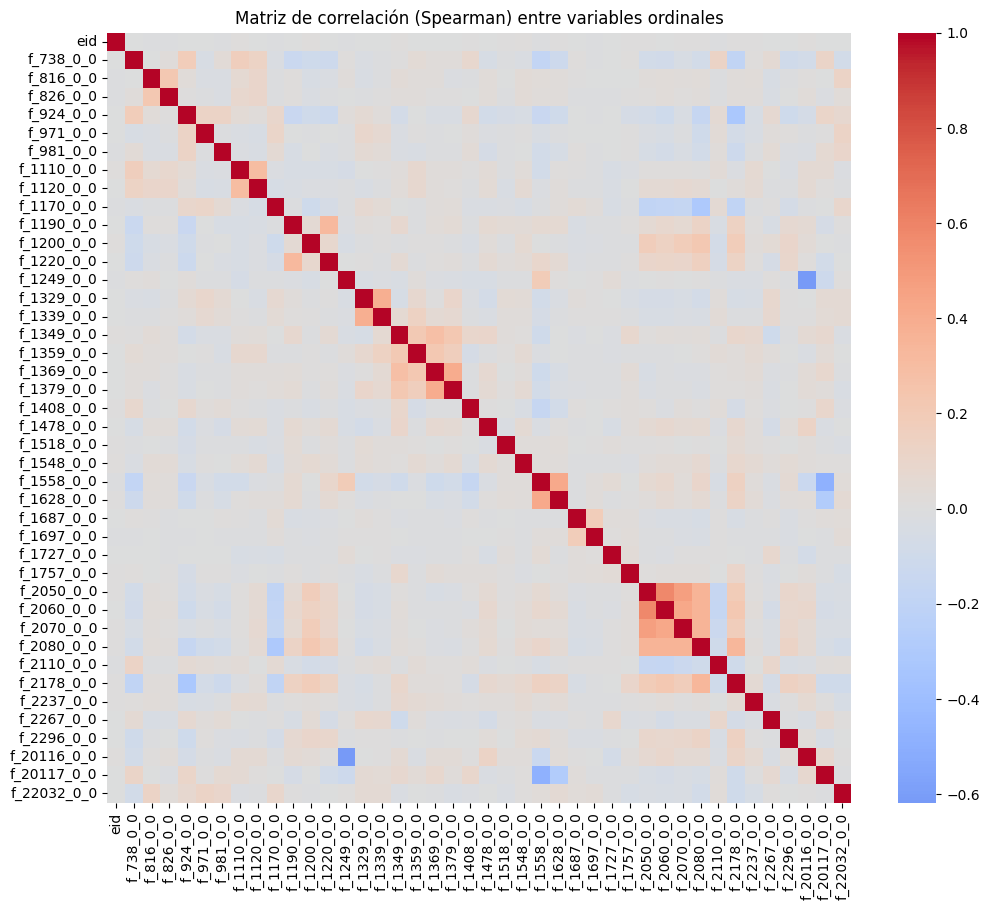

In [23]:
ordinal_df = categorical_simple_ordinal_df.drop(columns=['Disease'])

# 2. Matriz de correlación de Spearman
corr_matrix = ordinal_df.corr(method='spearman')

# Visualizarla
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de correlación (Spearman) entre variables ordinales')
plt.show()

In [24]:
# 3. Extraer pares de columnas correlacionadas fuertemente (|corr| > 0.7)
threshold = 0.7
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 4. Encuentra las columnas a eliminar
to_drop = set()

for col in upper_triangle.columns:
    high_corr = upper_triangle[col][abs(upper_triangle[col]) > threshold].index.tolist()
    to_drop.update(high_corr)  # Podrías hacer una lógica más inteligente si lo deseas

print(f"Columnas eliminadas por alta correlación: {list(to_drop)}")


Columnas eliminadas por alta correlación: []


Identificacion de datos fuertemente correlacionados para los datos categoricos nominales mediante el metodo de Cramér's V

In [25]:
categorical_simple_nominal_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_943_0_0,f_1100_0_0,f_1130_0_0,f_1140_0_0,f_1150_0_0,f_1180_0_0,...,f_2814_0_0,f_2834_0_0,f_2844_0_0,f_3393_0_0,f_3591_0_0,f_20160_0_0,f_21000_0_0,f_22035_0_0,f_22036_0_0,Disease
0,1000298,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,Control
1,1000767,1.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,2.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1001.0,1.0,1.0,IBD
2,1000952,1.0,2.0,3.0,2.0,1.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3001.0,1.0,1.0,Control
3,1001301,2.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,Control
4,1001358,1.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1001.0,0.0,1.0,Control


In [26]:
# ---------- 1. Definir función de Cramér's V ----------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Corrección por sesgo
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# ---------- 2. Excluir columnas no nominales ----------
excluded_cols = ['eid', 'Disease']
nominal_df = categorical_simple_nominal_df.drop(columns=excluded_cols)

# ---------- 3. Calcular matriz de Cramér's V ----------
columns = nominal_df.columns
n = len(columns)
cramers_matrix = pd.DataFrame(np.zeros((n, n)), columns=columns, index=columns)

for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            cramers_matrix.loc[col1, col2] = cramers_v(nominal_df[col1], nominal_df[col2])
        else:
            cramers_matrix.loc[col1, col2] = 1.0

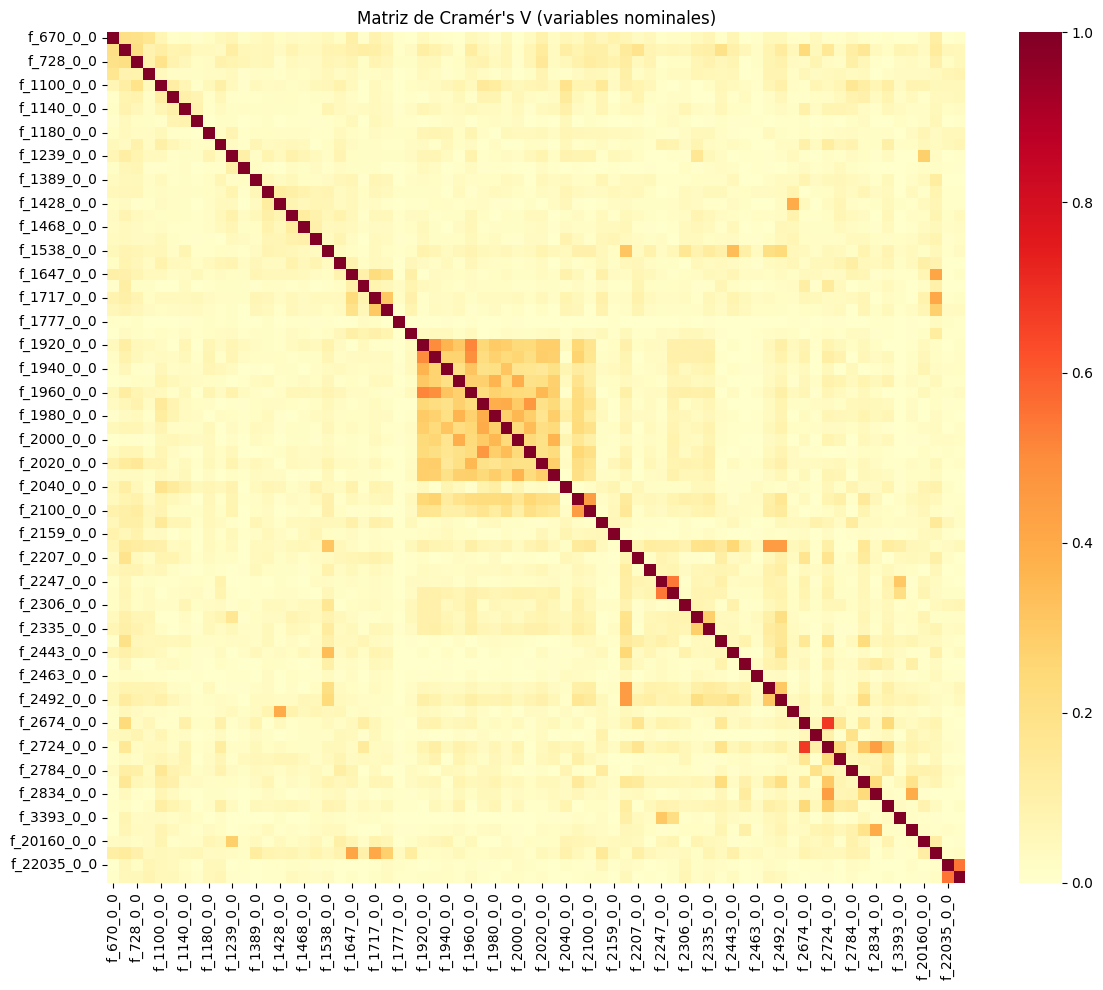

In [28]:
# ---------- 4. Visualizar matriz de asociación ----------
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, cmap='YlOrRd', center=0.5)
plt.title("Matriz de Cramér's V (variables nominales)")
plt.tight_layout()
plt.show()

In [29]:
# ---------- 5. Detectar columnas redundantes ----------
threshold = 0.75
to_drop = set()

# Evita eliminar ambas columnas de un par
for col in cramers_matrix.columns:
    high_corr = cramers_matrix[col][cramers_matrix[col] > threshold].index
    for redundant_col in high_corr:
        if redundant_col != col and redundant_col not in to_drop and col not in to_drop:
            to_drop.add(redundant_col)

print(f"Columnas eliminadas por alta asociación (Cramér’s V > {threshold}):")
print(sorted(to_drop))

Columnas eliminadas por alta asociación (Cramér’s V > 0.75):
[]


#### Procesamiento de datos categoricos simples nominales

Con la ayuda de los tres archivos se procede a hacer le onehot encoding.

In [31]:
# Paso 1 — Extraer FieldID desde los nombres de columna
fieldid_pattern = re.compile(r'f_(\d+)_\d+_\d+')
column_fieldid_map = {
    col: int(fieldid_pattern.search(col).group(1))
    for col in categorical_simple_nominal_df.columns
    if col != 'eid' and fieldid_pattern.search(col)
}

# Paso 2 — Mapa FieldID → Coding (desde touchscreen_chars_df)
touchscreen_chars_df = touchscreen_chars_df.dropna(subset=['Coding'])
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)
touchscreen_chars_df['Coding'] = touchscreen_chars_df['Coding'].astype(int)
fieldid_to_coding = touchscreen_chars_df.set_index('FieldID')['Coding'].to_dict()

In [32]:
def process_column(col, fieldid, coding, col_values, valid_codes):
    if coding is None:
        return []

    present_values = col_values.dropna().unique()

    used_codes = [code for code in valid_codes if code in present_values]

    result = []
    for code in used_codes:
        new_col_name = f'f_{fieldid}_{coding}_{code}'
        mask_valid = col_values.notna()
        encoded_col = np.where(mask_valid, (col_values == code).astype(int), pd.NA)
        result.append((new_col_name, encoded_col))

    return result

In [33]:
# Paso 4 — Preparar datos
eid = categorical_simple_nominal_df['eid']
encoded_data = {'eid': eid}
tasks = []

for col, fieldid in column_fieldid_map.items():
    if col not in categorical_simple_nominal_df.columns:
        continue

    coding = fieldid_to_coding.get(fieldid)
    valid_cbkeys = touchscreen_cbkeys_df[touchscreen_cbkeys_df['coding_name'] == coding]
    valid_codes = valid_cbkeys['code'].unique()
    col_values = categorical_simple_nominal_df[col]
    
    tasks.append((col, fieldid, coding, col_values, valid_codes))

# Paso 5 — Ejecutar en paralelo
results = Parallel(n_jobs=-1)(
    delayed(process_column)(col, fid, cod, vals, vcodes)
    for col, fid, cod, vals, vcodes in tasks
)

# Paso 6 — Construir DataFrame final
for col_results in results:
    for new_col_name, values in col_results:
        encoded_data[new_col_name] = values

categorical_simple_nominal_onehot_df = pd.DataFrame(encoded_data)

# Mostrar vista previa
categorical_simple_nominal_onehot_df.head()

,eid,f_670_100286_1,f_670_100286_2,f_670_100286_3,f_670_100286_4,f_670_100286_5,f_680_100287_1,f_680_100287_2,f_680_100287_3,f_680_100287_4,...,f_21000_1001_3004,f_21000_1001_4001,f_21000_1001_4002,f_21000_1001_4003,f_21000_1001_5,f_21000_1001_6,f_22035_7_1,f_22035_7_0,f_22036_7_1,f_22036_7_0
0,1000298,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,1000767,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1000952,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1001301,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
4,1001358,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [34]:
categorical_simple_nominal_onehot_df.shape

(22625, 228)

#### Procesamiento de datos categoricos multiples 

In [35]:
categorical_multiple_df.shape

(22625, 100)

In [36]:
# Paso 0: Asegurar que las columnas tengan tipo correcto (memoria eficiente)
for col in categorical_multiple_df.columns:
    if col != 'eid':
        categorical_multiple_df.loc[:, col] = categorical_multiple_df[col].astype("Int32")  # permite NaN

# Paso 1: Extraer FieldID desde nombres de columnas
pattern = re.compile(r'f_(\d+)_0_\d+')

column_fieldid_map = {
    col: int(pattern.search(col).group(1))
    for col in categorical_multiple_df.columns
    if col != 'eid' and pattern.search(col)
}

# Paso 2: Mapeo FieldID → Coding
touchscreen_chars_df = touchscreen_chars_df.dropna(subset=['Coding'])
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)
touchscreen_chars_df['Coding'] = touchscreen_chars_df['Coding'].astype(int)

fieldid_to_coding = touchscreen_chars_df.set_index('FieldID')['Coding'].to_dict()

# Paso 3: Agrupar columnas por FieldID
fieldid_to_columns = defaultdict(list)
for col, fieldid in column_fieldid_map.items():
    fieldid_to_columns[fieldid].append(col)

# Paso 4: Función optimizada para procesar un FieldID
def process_field_optimized(fieldid, cols):
    coding = fieldid_to_coding.get(fieldid)
    if coding is None:
        return None

    valid_codes = touchscreen_cbkeys_df[
        (touchscreen_cbkeys_df['coding_name'] == coding) &
        (~touchscreen_cbkeys_df['code'].isin([]))
    ]['code'].unique()

    sub_df = categorical_multiple_df[cols].copy()
    sub_df['eid'] = categorical_multiple_df['eid']

    # Transformar de formato ancho a largo
    long_df = sub_df.melt(id_vars='eid', value_name='code')
    long_df = long_df.dropna()
    long_df['code'] = long_df['code'].astype(int)

    # Filtrar solo códigos válidos
    long_df = long_df[long_df['code'].isin(valid_codes)]

    # Crear variables dummy agrupadas por eid y código
    onehot = (
        long_df
        .assign(dummy=1)
        .pivot_table(index='eid', columns='code', values='dummy', fill_value=0)
        .astype("Int8")
    )

    # Renombrar columnas
    onehot.columns = [f'f_{fieldid}_{coding}_{code}' for code in onehot.columns]
    
    return onehot

# Paso 5: Procesar en paralelo todos los FieldID
results = Parallel(n_jobs=-1)(
    delayed(process_field_optimized)(fieldid, cols)
    for fieldid, cols in fieldid_to_columns.items()
)

# Paso 6: Combinar resultados válidos
valid_results = [df for df in results if df is not None]

if valid_results:
    encoded_df = reduce(lambda left, right: left.join(right, how='outer'), valid_results)
    encoded_df = encoded_df.reset_index()

    # Reordenar columnas para asegurar que 'eid' está primero
    cols = ['eid'] + [col for col in encoded_df.columns if col != 'eid']
    encoded_df = encoded_df[cols]
else:
    encoded_df = categorical_multiple_df[['eid']].copy()

# Resultado final
categorical_multiple_onehot_df = encoded_df

# Mostrar muestra del resultado
categorical_multiple_onehot_df.head()

/tmp/ipykernel_6688/1530716304.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[5, 5, 5, 4, 5, 4, 4, 5, 5, 5,
 ...
 4, 4, 5, 4, 4, 3, 5, 4, 5, 5]
Length: 22625, dtype: Int32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  categorical_multiple_df.loc[:, col] = categorical_multiple_df[col].astype("Int32")  # permite NaN
/tmp/ipykernel_6688/1530716304.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[<NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 ...
 <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
Length: 22625, dtype: Int32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  categorical_multiple_df.loc[:, col] = categorical_multiple_df[col].astype("Int32")  # permite NaN
/tmp/ipykernel_6688/1530716304

,eid,f_6144_100385_1,f_6144_100385_2,f_6144_100385_3,f_6144_100385_4,f_6144_100385_5,f_6146_100510_1,f_6146_100510_2,f_6146_100510_3,f_6147_100514_1,...,f_20111_1010_3,f_20111_1010_4,f_20111_1010_5,f_20111_1010_6,f_20111_1010_8,f_20111_1010_9,f_20111_1010_10,f_20111_1010_11,f_20111_1010_12,f_20111_1010_13
0,1000298,0,0,0,0,1,<NA>,<NA>,<NA>,1,...,0,0,0,0,1,0,0,0,0,0
1,1000767,0,0,0,0,1,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,1,0,0,0,0,0
2,1000952,0,0,0,0,1,<NA>,<NA>,<NA>,0,...,0,0,0,0,0,0,0,0,0,0
3,1001301,0,0,0,1,0,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1001358,0,0,0,0,1,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [37]:
categorical_multiple_onehot_df.shape

(22599, 154)

Eliminacion de columnas con NA mayor a 50%

In [38]:
threshold = 0.5 * len(categorical_multiple_onehot_df)

categorical_multiple_onehot_df = categorical_multiple_onehot_df.dropna(thresh=threshold, axis=1)

categorical_multiple_onehot_df.shape

(22599, 45)

# Imputacion segun la moda datos categoricos multiples 

In [39]:
categorical_multiple_onehot_df = categorical_multiple_onehot_df.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

categorical_multiple_onehot_df['Disease'] = categorical_multiple_onehot_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

categorical_multiple_onehot_df['Disease'].value_counts(dropna=False)

Disease
Control    18978
IBD         3621
Name: count, dtype: int64

In [40]:
categorical_multiple_onehot_df = impute(categorical_multiple_onehot_df) 

categorical_multiple_onehot_df.shape

(22599, 46)

#### Procesamiento de datos numericos 

Eliminacion de columnas con un mas 50% de datos faltantes

In [41]:
threshold = 0.5 * len(categorical_multiple_onehot_df)

#categorical_multiple_onehot_df = categorical_multiple_onehot_df.dropna(thresh=threshold, axis=1)
numeric_df = numeric_df.dropna(thresh=threshold, axis=1)

#categorical_multiple_onehot_df.shape
numeric_df.shape

(22625, 47)

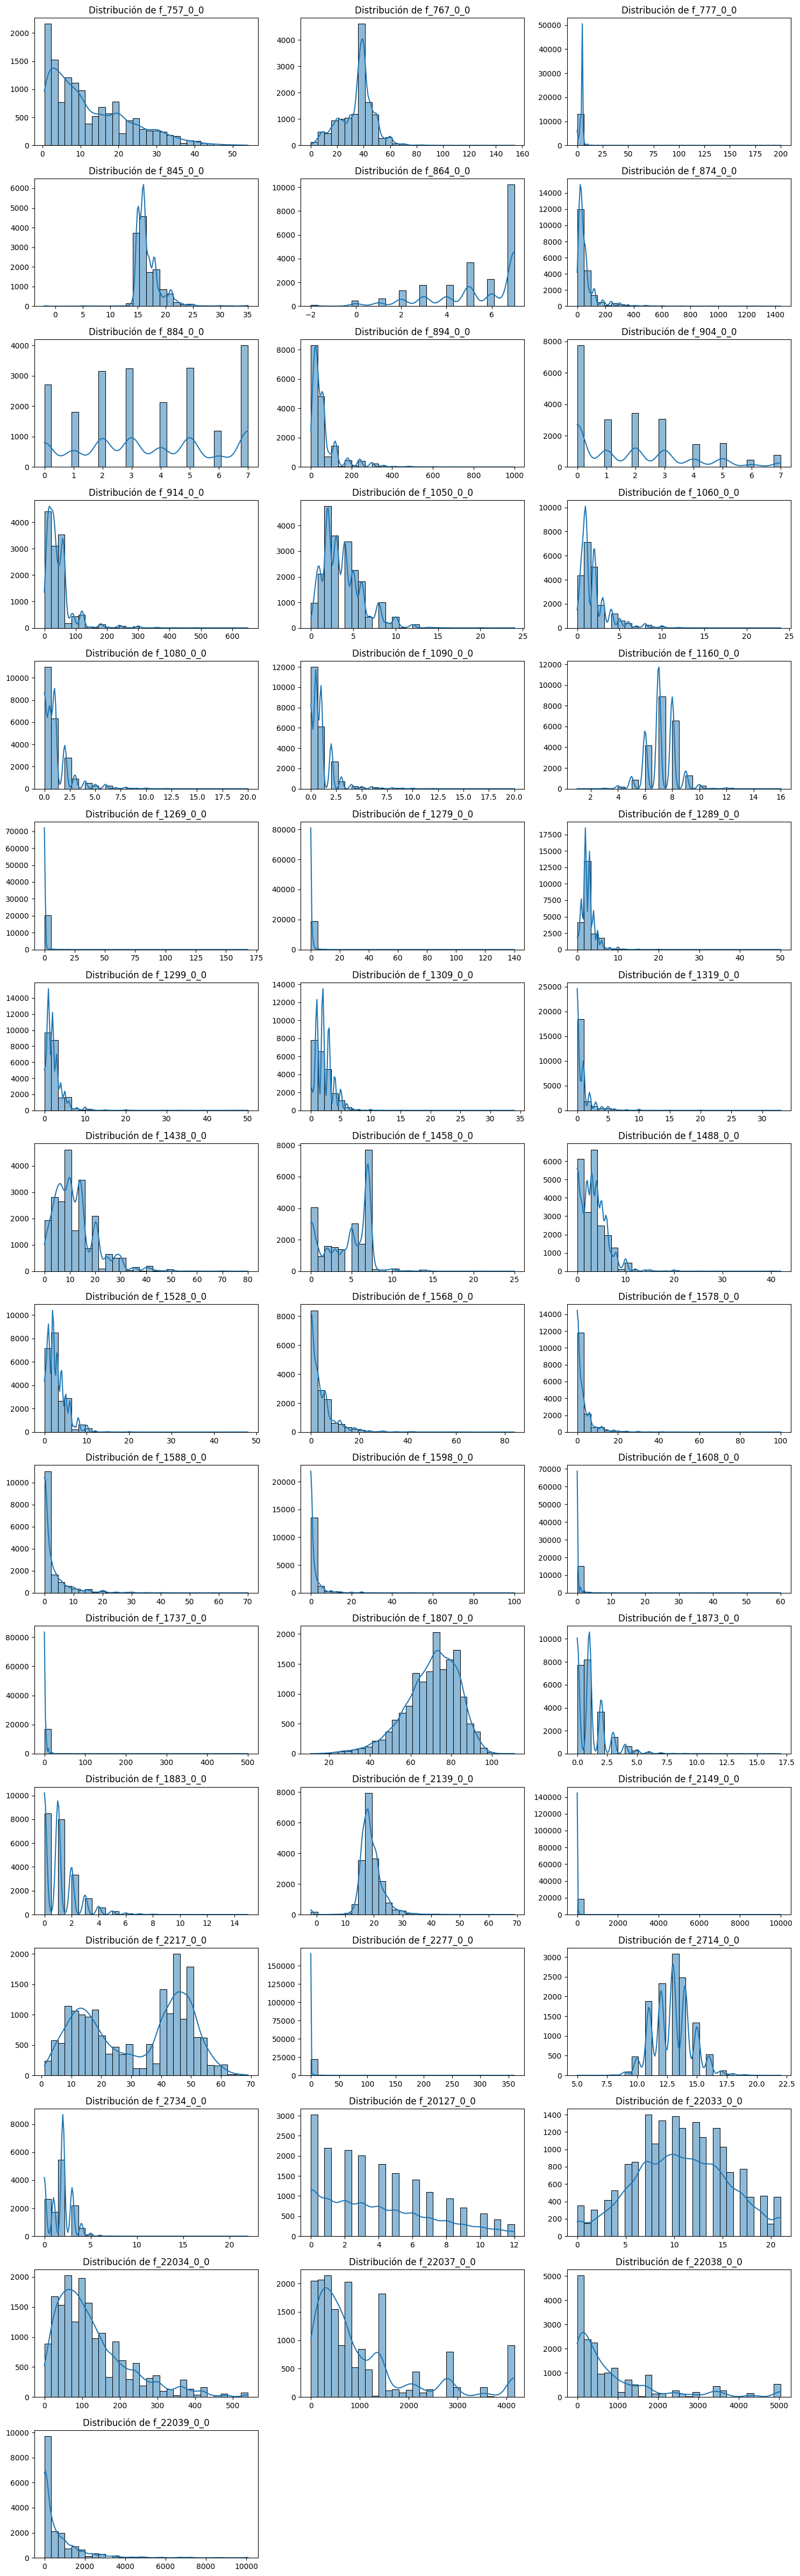

In [42]:
numeric_columns = numeric_df.columns.drop('eid')
num_plots = len(numeric_columns)

ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(numeric_df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Si hay más subplots que columnas, apaga los sobrantes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


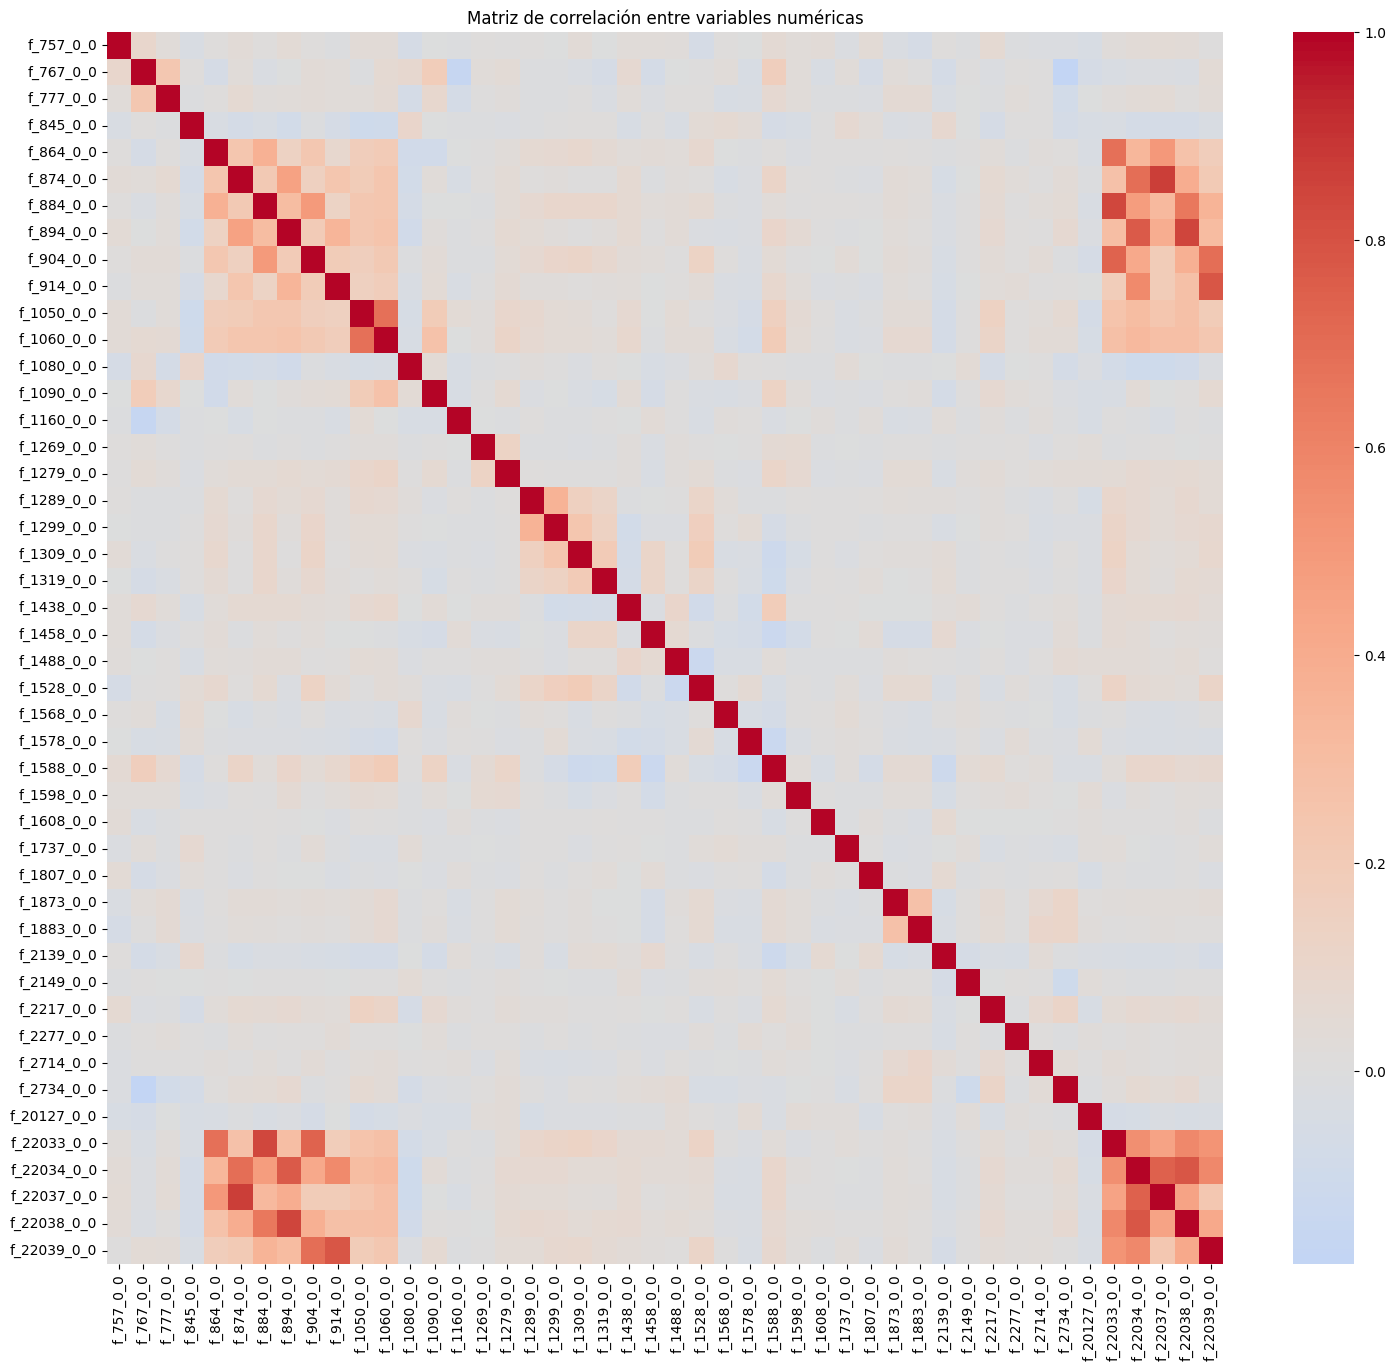

In [43]:
plt.figure(figsize=(18, 16))
corr = numeric_df.drop(columns='eid').corr()

sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

In [44]:
nan_percent = (numeric_df.isna().sum() / len(numeric_df)) * 100
nan_percent = nan_percent[nan_percent > 0]

# Mostrar porcentaje
print("Porcentaje de NaNs por columna:")
display(nan_percent.sort_values(ascending=False))


Porcentaje de NaNs por columna:


f_2714_0_0     45.043094
f_914_0_0      44.455249
f_2734_0_0     43.341436
f_777_0_0      40.769061
f_767_0_0      40.627624
f_757_0_0      40.017680
f_845_0_0      37.396685
f_1598_0_0     30.841989
f_1578_0_0     30.788950
f_1568_0_0     30.758011
f_1608_0_0     30.625414
f_1588_0_0     30.572376
f_1807_0_0     29.600000
f_894_0_0      25.582320
f_1737_0_0     24.234254
f_22037_0_0    22.117127
f_22033_0_0    22.117127
f_22034_0_0    22.117127
f_22038_0_0    22.117127
f_22039_0_0    22.117127
f_20127_0_0    19.712707
f_2149_0_0     18.766851
f_2217_0_0     16.649724
f_1279_0_0     14.912707
f_874_0_0      14.479558
f_2139_0_0     11.867403
f_1269_0_0      9.184530
f_1050_0_0      6.422099
f_1060_0_0      6.232044
f_904_0_0       5.016575
f_884_0_0       4.998895
f_1090_0_0      1.913812
f_2277_0_0      1.851934
f_1873_0_0      1.807735
f_1883_0_0      1.772376
f_1438_0_0      1.706077
f_1080_0_0      1.507182
f_864_0_0       1.462983
f_1319_0_0      1.383425
f_1299_0_0      1.379006


In [45]:
# Función para construir el mapa FieldID → nombre de pregunta
def get_fieldid_to_name_map(touchscreen_chars_df):
    df = touchscreen_chars_df.dropna(subset=['FieldID', 'Field']).copy()
    df['FieldID'] = df['FieldID'].astype(int)
    df['Field'] = df['Field'].str.strip()
    return dict(zip(df['FieldID'], df['Field']))

# Extraer el FieldID desde un nombre de columna tipo 'f_1234_0_0'
def extract_field_id(colname):
    match = re.match(r'f_(\d+)_\d+_\d+', colname)
    if match:
        return int(match.group(1))
    return None

# Crear el mapa de FieldIDs
fieldid_to_name = get_fieldid_to_name_map(touchscreen_chars_df)

# Calcular la matriz de correlación
corr_matrix = numeric_df.drop(columns='eid').corr().abs()

# Tomar solo la parte superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extraer los pares con correlación > 0.75
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'Variable1', 'level_1': 'Variable2'})
)

high_corr_pairs = high_corr_pairs[high_corr_pairs['correlation'] > 0.75]

# Agregar columnas con FieldID
high_corr_pairs['FieldID1'] = high_corr_pairs['Variable1'].apply(extract_field_id)
high_corr_pairs['FieldID2'] = high_corr_pairs['Variable2'].apply(extract_field_id)

# Renombrar variables si el FieldID tiene nombre mapeado
high_corr_pairs['Variable1'] = high_corr_pairs['FieldID1'].apply(lambda fid: fieldid_to_name.get(fid, f'f_{fid}' if fid else 'Unknown'))
high_corr_pairs['Variable2'] = high_corr_pairs['FieldID2'].apply(lambda fid: fieldid_to_name.get(fid, f'f_{fid}' if fid else 'Unknown'))

# Ordenar por correlación
high_corr_pairs = high_corr_pairs.sort_values(by='correlation', ascending=False)

# Mostrar el resultado
print("Pares altamente correlacionados")
display(high_corr_pairs)

Pares altamente correlacionados


,Variable1,Variable2,correlation,FieldID1,FieldID2
252,Duration of walks,f_22037,0.868352,874,22037
330,Duration of moderate activity,f_22038,0.847422,894,22038
289,Number of days/week of moderate physical activ...,f_22033,0.833728,884,22033
404,Duration of vigorous activity,f_22039,0.786305,914,22039
1030,f_22034,f_22038,0.780324,22034,22038
328,Duration of moderate activity,f_22034,0.766395,894,22034


Eliminacion de variables altamente relacionadas 

| FiledID | Field                            |
|---------|----------------------------------|
| 22037   | MET minutes per week for walking |
| 22038   | MET minutes per week for moderate activity |
| 884     | Number of days/week of moderate physical activity 10+ minutes |
| 22039   | MET minutes per week for vigorous activity |
| 22038   | MET minutes per week for moderate activity |
| 894     | Duration of moderate activity |

In [46]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [ "22037", "22038", "884", "22039", "894" ]

# Create a regex pattern to match columns with the specified IDs
pattern = re.compile(rf"^f_({'|'.join(irrelevant_ids)})_\d+_\d+$")

# Find columns that match the pattern
columns_to_drop = [col for col in numeric_df.columns if pattern.match(col)]

# Drop the identified columns from the DataFrame
numeric_df = numeric_df.drop(columns=columns_to_drop)

# Validate the drop by checking the remaining columns
print(numeric_df.shape)

(22625, 42)


Boxplots to see outliers

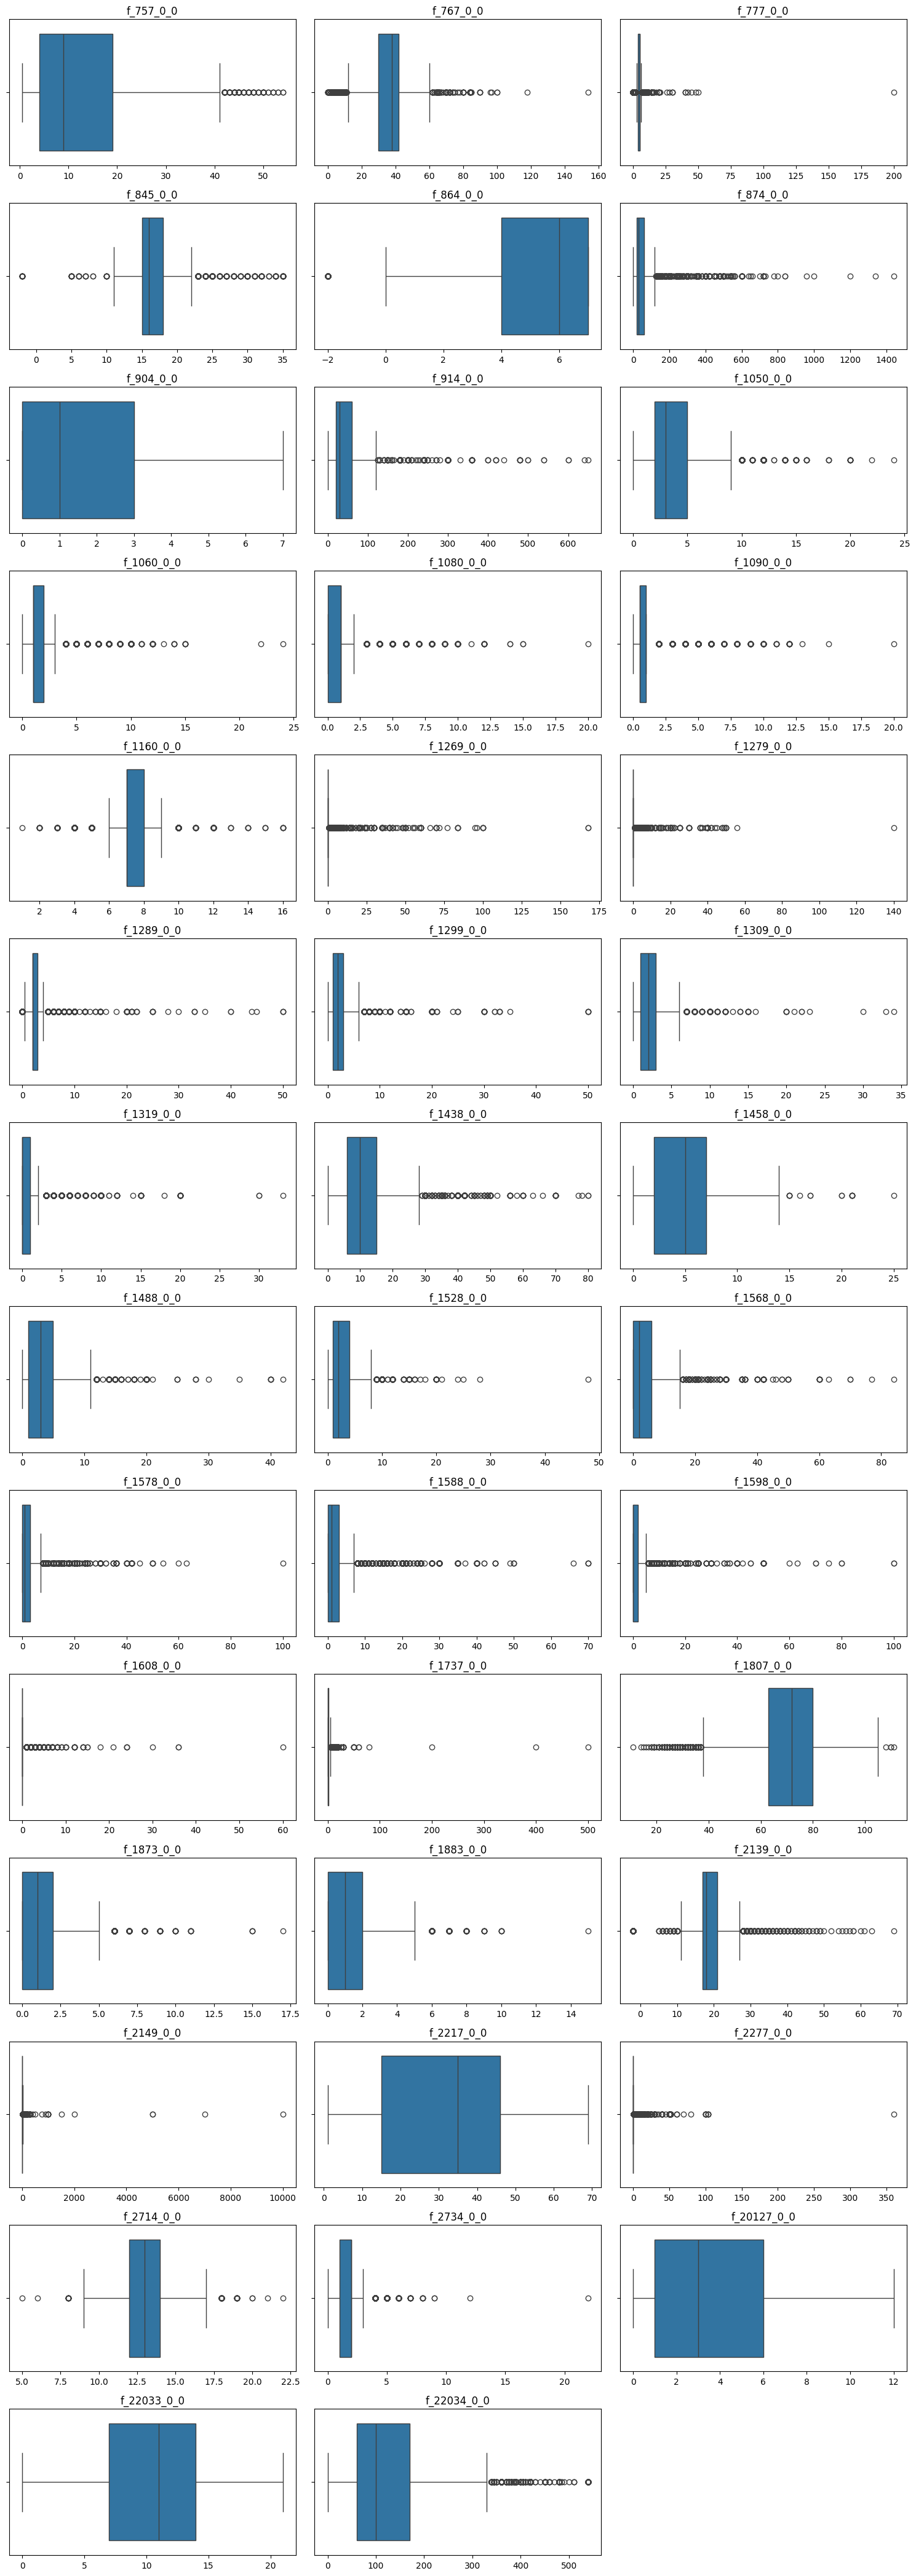

In [47]:
cols = numeric_df.columns.drop('eid')  # Quitamos la columna 'eid'
n = len(cols)
ncols = 3                              # 3 columnas
nrows = math.ceil(n / ncols)          # Número de filas necesario

# Crear una sola figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()  # Para recorrerlos fácilmente

# Crear los boxplots
for i, col in enumerate(cols):
    sns.boxplot(x=numeric_df[col].dropna(), ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Apagar los ejes sobrantes si hay menos gráficos que subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Como se maneja un data set con gran cantidad de datos y con varias dimensiones, se decide para la imputacion la utilizacion de isolation forest. Para esto se hace la normalizacion de los datos para luego implementar el modelo para encontrar los outliers y generar dos nuevos datasets sin los outliers.

In [48]:
# Guardamos solo las variables numéricas sin 'eid'
features_df = numeric_df.drop(columns=['eid'])

# Escalamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_df)

# Creamos y entrenamos el modelo
iso_forest = IsolationForest(contamination='auto', random_state=42)
outlier_labels = iso_forest.fit_predict(scaled_data)

# Añadimos los resultados a numeric_df
numeric_df['outlier'] = outlier_labels

# Obtenemos solo los índices de las filas NO outliers
valid_indices = numeric_df[numeric_df['outlier'] == 1]['eid']

# Filtramos ambos DataFrames usando esos 'eid' 
numeric_df_clean = numeric_df[numeric_df['eid'].isin(valid_indices)].drop(columns='outlier')
categorical_multiple_df_clean = categorical_multiple_onehot_df[categorical_multiple_onehot_df['eid'].isin(valid_indices)]
#categorical_simple_df_clean = categorical_simple_onehot_df[categorical_simple_onehot_df['eid'].isin(valid_indices)]
categorical_multiple_onehot_df = categorical_multiple_onehot_df[categorical_multiple_onehot_df['eid'].isin(valid_indices)]
categorical_simple_ordinal_df_clean = categorical_simple_ordinal_df[categorical_simple_ordinal_df['eid'].isin(valid_indices)]
categorical_simple_nominal_df_clean = categorical_simple_nominal_df[categorical_simple_nominal_df['eid'].isin(valid_indices)]   

n_total = numeric_df.shape[0]
n_removed = n_total - len(valid_indices)
print(f'Se eliminaron {n_removed} outliers de un total de {n_total} filas.')

Se eliminaron 331 outliers de un total de 22625 filas.


Visualizaciond e las nuevas distribuciones y bloxplots.

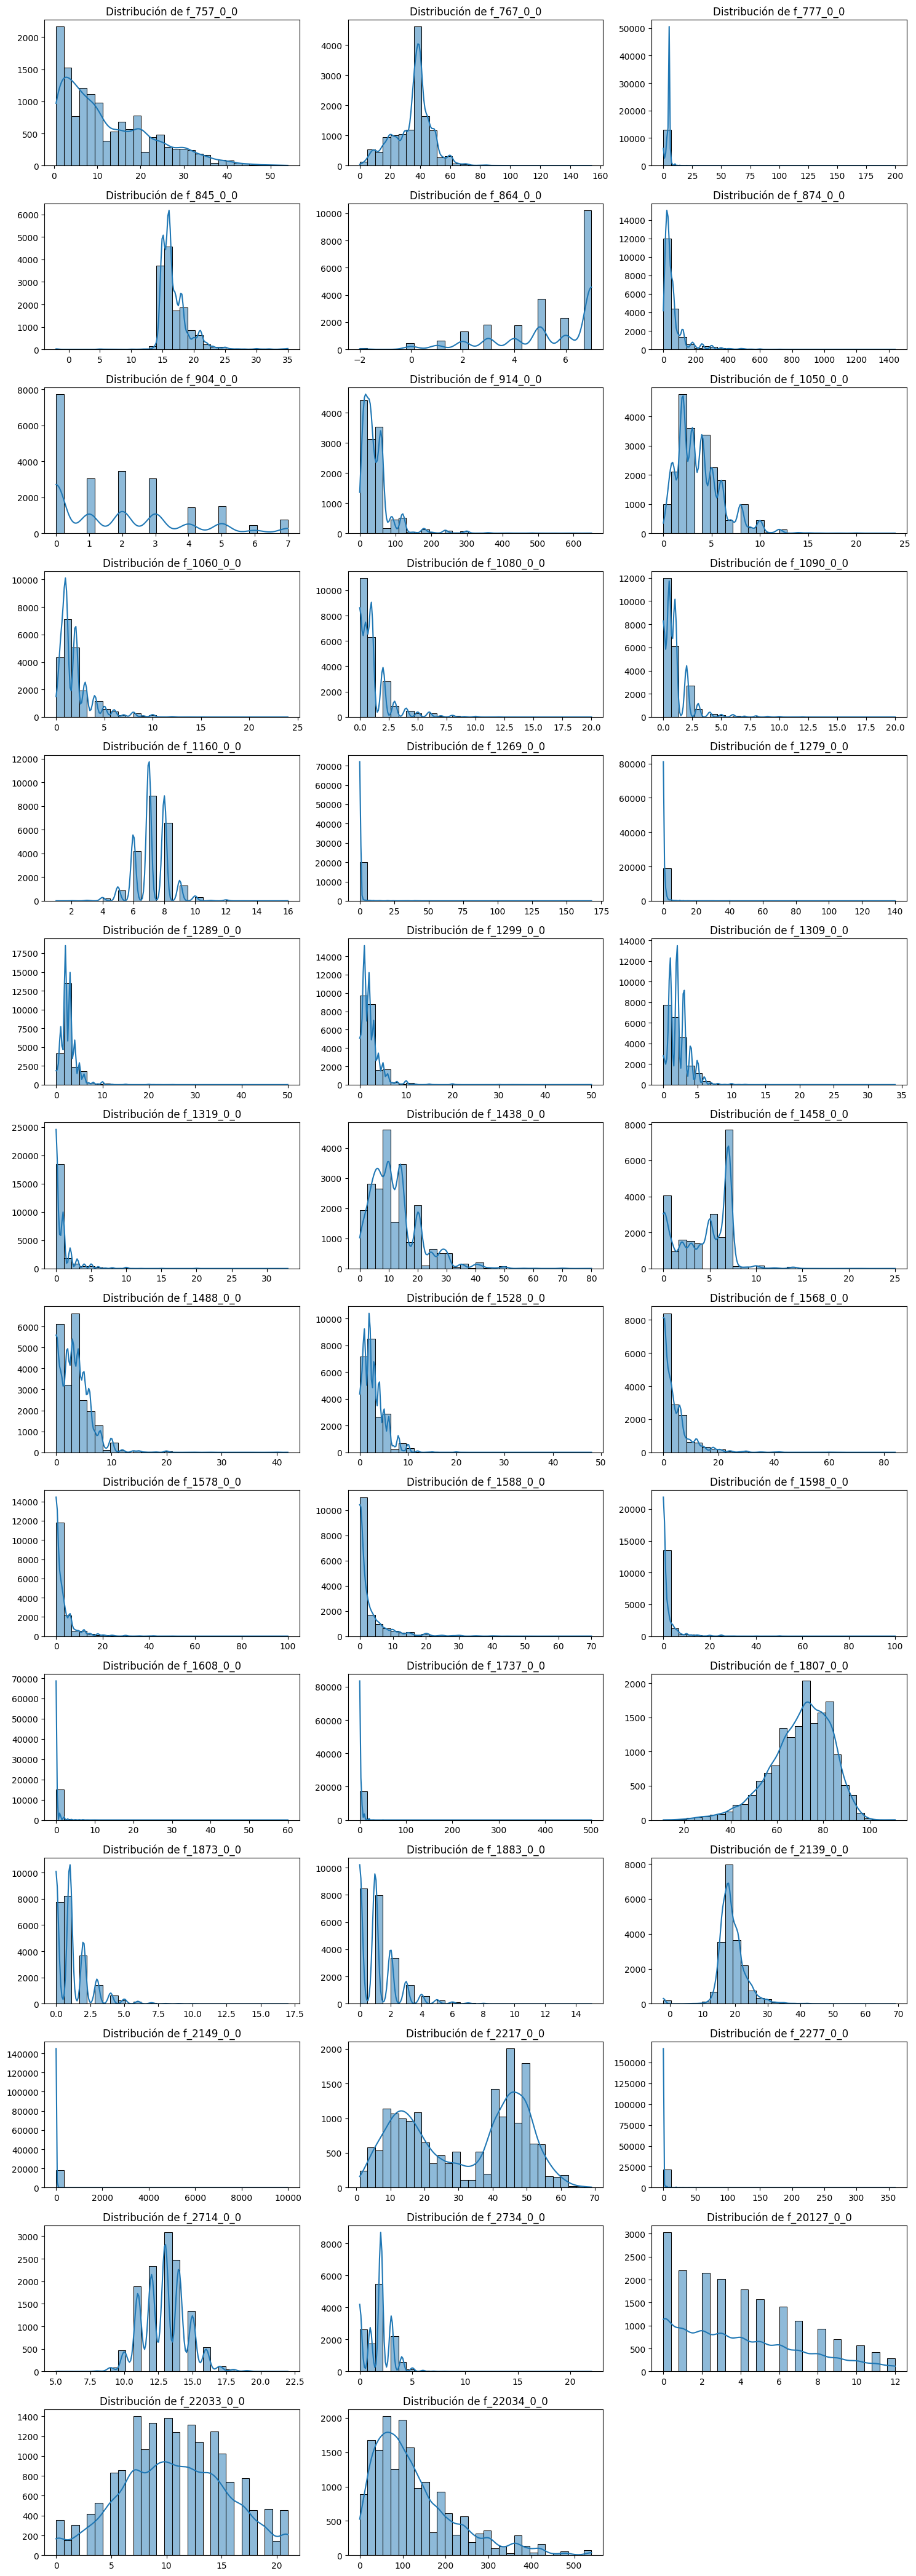

In [49]:
numeric_columns = numeric_df_clean.columns.drop('eid')
num_plots = len(numeric_columns)

ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(numeric_df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Si hay más subplots que columnas, apaga los sobrantes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

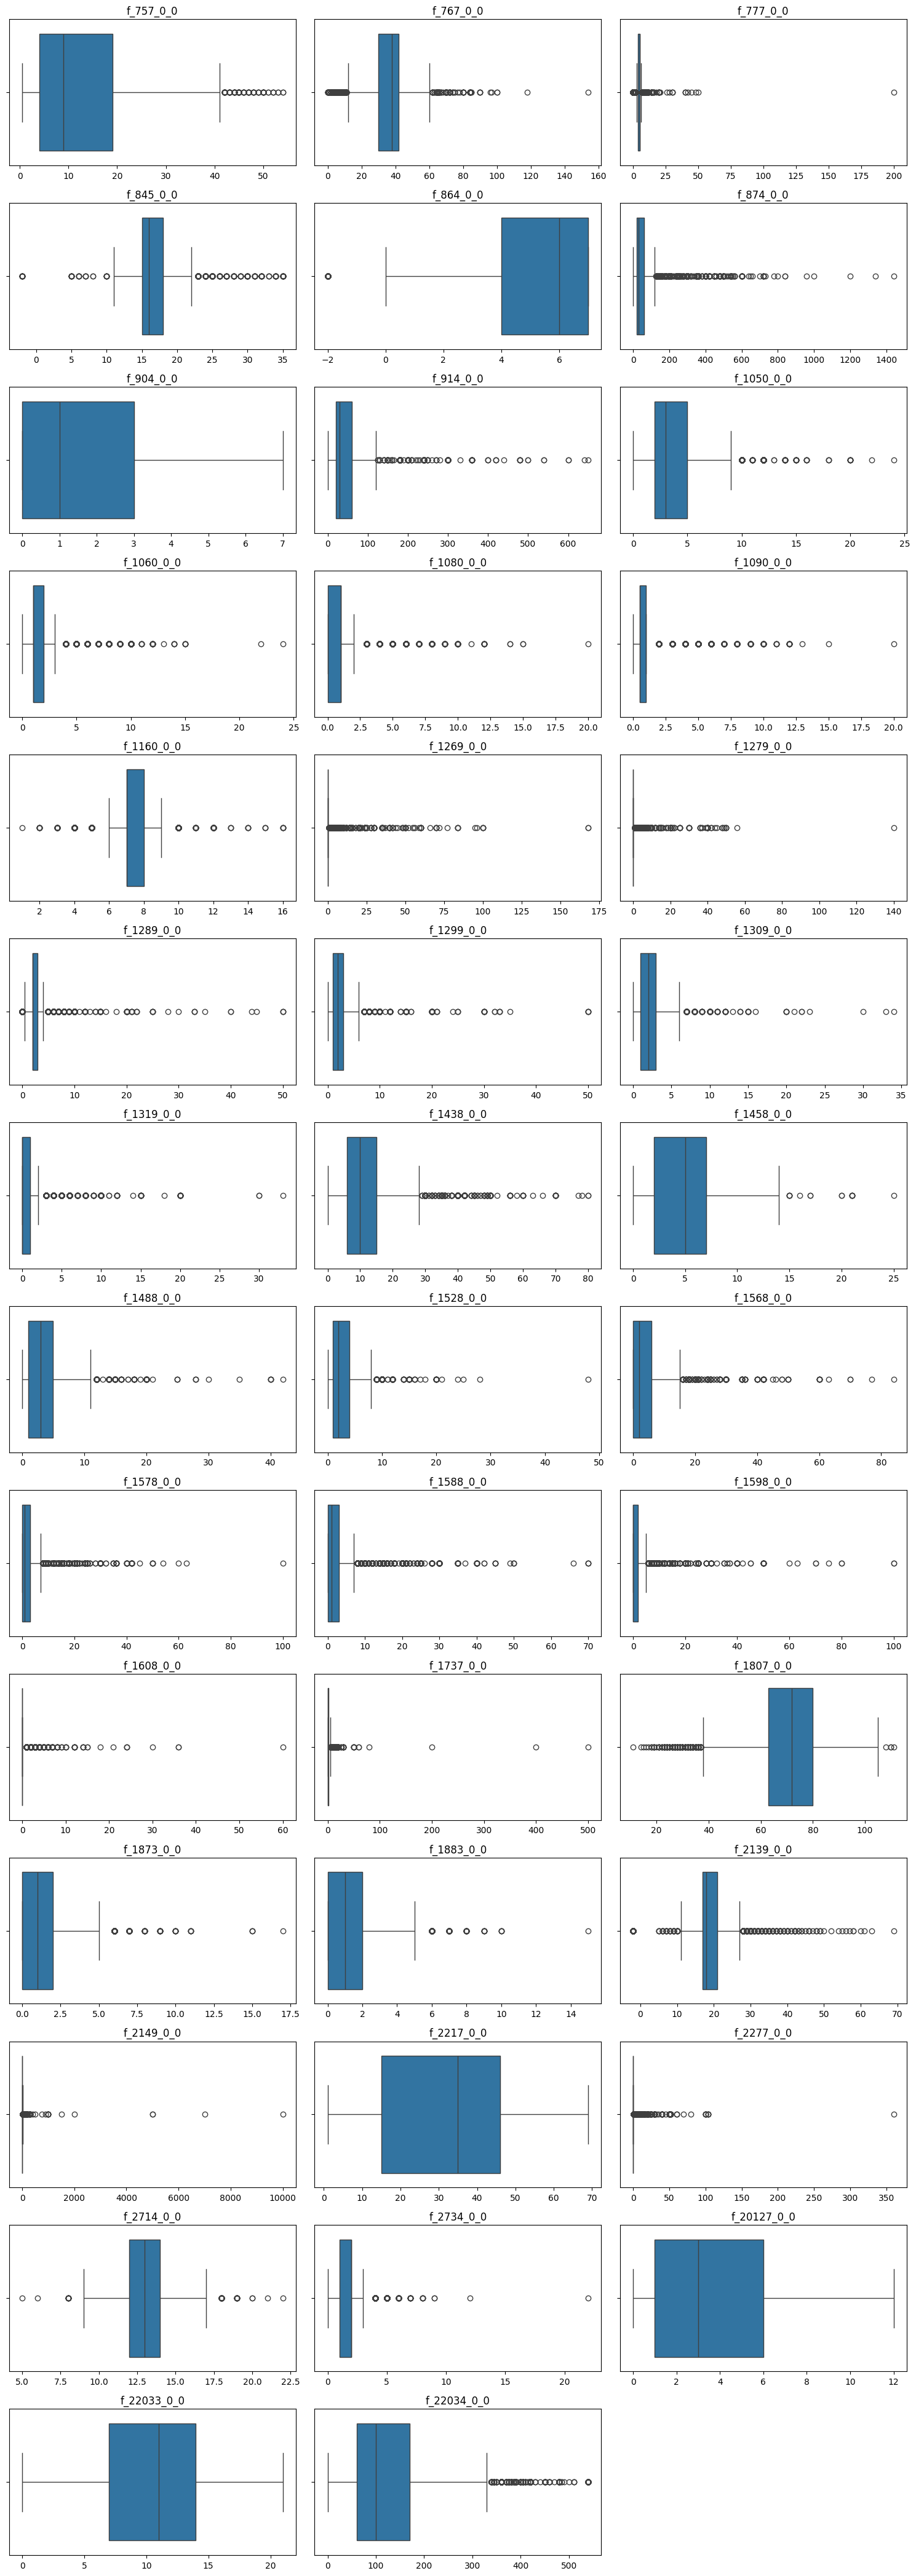

In [50]:
cols = numeric_df_clean.columns.drop('eid')  # Quitamos la columna 'eid'
n = len(cols)
ncols = 3                              # 3 columnas
nrows = math.ceil(n / ncols)          # Número de filas necesario

# Crear una sola figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()  # Para recorrerlos fácilmente

# Crear los boxplots
for i, col in enumerate(cols):
    sns.boxplot(x=numeric_df[col].dropna(), ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Apagar los ejes sobrantes si hay menos gráficos que subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Imputacion por moda

In [51]:
numeric_df_clean = numeric_df_clean.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

numeric_df_clean['Disease'] = numeric_df_clean['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

numeric_df_clean['Disease'].value_counts(dropna=False)

Disease
Control    18728
IBD         3566
Name: count, dtype: int64

Exception ignored in: <function ResourceTracker.__del__ at 0x7f94ba68c220>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


In [52]:
numeric_df_clean = impute(numeric_df_clean)
numeric_df_clean.shape

Exception ignored in: <function ResourceTracker.__del__ at 0x7fe93bb84220>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fc868b88220>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f290dd8c220>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

(22294, 43)

In [53]:
#Escalar
from sklearn.preprocessing import StandardScaler

def scale_numeric_columns(df, id_col='eid'):
    """
    Escala las columnas numéricas del DataFrame, excluyendo la columna id_col.

    Parámetros:
        df (pd.DataFrame): DataFrame a escalar.
        id_col (str): Nombre de la columna de identificación (no se escala).

    Retorna:
        pd.DataFrame: DataFrame con columnas numéricas escaladas y id_col intacta.
    """
    df = df.copy()

    if id_col not in df.columns:
        raise ValueError(f"La columna '{id_col}' no está en el DataFrame.")

    # Separar columna ID
    id_series = df[[id_col]].astype(str)

    # Seleccionar columnas numéricas
    numeric_df = df.drop(columns=[id_col]).select_dtypes(include=[np.number])

    # Escalar
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(numeric_df)
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=numeric_df.index)

    # Concatenar columna ID y columnas escaladas
    return pd.concat([id_series, scaled_df], axis=1)

touchscreen_numeric_scaled=scale_numeric_columns(numeric_df_clean)
    
touchscreen_numeric_standard=scale_numeric_columns(touchscreen_numeric_scaled)
touchscreen_numeric_standard

,eid,f_757_0_0,f_767_0_0,f_777_0_0,f_845_0_0,f_864_0_0,f_874_0_0,f_904_0_0,f_914_0_0,f_1050_0_0,...,f_1883_0_0,f_2139_0_0,f_2149_0_0,f_2217_0_0,f_2277_0_0,f_2714_0_0,f_2734_0_0,f_20127_0_0,f_22033_0_0,f_22034_0_0
0,1000298,-0.662214,0.272817,0.205356,-0.238056,0.315049,-0.497041,1.667540,-0.924929,-0.682776,...,0.803900,1.987693,-0.064498,0.390844,-0.115701,0.011725,0.139070,-0.655266,1.357739,-0.489621
1,1000767,-0.662214,0.272817,0.205356,1.224392,-1.208310,-0.356960,0.116574,-1.223898,-0.682776,...,-0.027793,0.520484,0.006289,0.329102,-0.115701,0.011725,0.139070,-0.043404,0.026337,-0.489621
2,1000952,0.394209,-0.029854,0.205356,1.711874,0.822835,-0.356960,-0.917403,0.270948,-1.338738,...,0.803900,-0.213121,-0.078656,0.823038,-0.115701,0.844174,1.221243,-0.961196,-0.639365,-0.602821
3,1001301,-0.450930,1.281720,0.689923,-0.238056,-2.223883,-0.356960,-0.400415,0.270948,-1.120084,...,-0.859486,-0.213121,-0.078656,0.699554,-0.115701,0.011725,0.139070,2.709971,-0.639365,-0.602821
4,1001358,1.028063,-0.029854,0.205356,-0.238056,-1.716097,0.063285,-0.400415,-1.223898,-1.120084,...,-0.027793,0.765019,-0.007869,0.699554,-0.115701,0.011725,0.139070,0.262526,-1.083165,0.189580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22289,6021563,-0.662214,0.272817,0.205356,-0.725539,0.822835,-0.356960,-0.917403,0.270948,-0.682776,...,-0.859486,-0.213121,-0.078656,0.699554,-0.115701,-0.820725,0.139070,-0.655266,-0.639365,-0.602821
22290,6021667,0.816778,1.281720,0.205356,-0.238056,-1.716097,-0.567082,-0.917403,0.270948,-0.682776,...,-0.027793,-0.213121,0.034604,1.193491,-0.115701,0.011725,0.139070,-0.961196,-1.748867,-1.112222
22291,6021888,0.711136,2.996856,-2.217483,0.249426,0.822835,-0.356960,-0.400415,0.270948,0.629147,...,-0.027793,-0.213121,-0.078656,-1.461418,-0.115701,-1.653174,-2.025277,-0.961196,-0.639365,-0.602821
22292,6021914,-0.662214,0.272817,0.205356,-0.725539,-0.192737,-0.567082,-0.917403,0.270948,-0.245468,...,3.298980,-0.457656,-0.078656,0.082134,-0.115701,0.844174,-2.025277,2.709971,-0.639365,-0.602821


In [54]:
#Estandarizar

def scale_numeric_columns(df, id_col='eid'):
    """
    Escala columnas numéricas con StandardScaler, dejando la columna id_col sin cambios y en string.

    Parámetros:
        df (pd.DataFrame): DataFrame con datos.
        id_col (str): Nombre de la columna categórica a preservar (ej. 'eid').

    Retorna:
        pd.DataFrame: DataFrame con columnas numéricas escaladas y id_col como string.
    """
    df = df.copy()

    # Convertir id_col a string
    id_series = df[[id_col]].astype(str)

    # Seleccionar solo columnas numéricas excepto id_col
    numeric_df = df.drop(columns=[id_col]).select_dtypes(include=[np.number])

    # Escalar columnas numéricas
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(numeric_df)
    scaled_df = pd.DataFrame(scaled_array, columns=numeric_df.columns, index=numeric_df.index)

    # Concatenar columna id_col y columnas escaladas
    return pd.concat([id_series, scaled_df], axis=1)
    
    
touchscreen_numeric_standard=scale_numeric_columns(touchscreen_numeric_scaled)
touchscreen_numeric_standard

,eid,f_757_0_0,f_767_0_0,f_777_0_0,f_845_0_0,f_864_0_0,f_874_0_0,f_904_0_0,f_914_0_0,f_1050_0_0,...,f_1883_0_0,f_2139_0_0,f_2149_0_0,f_2217_0_0,f_2277_0_0,f_2714_0_0,f_2734_0_0,f_20127_0_0,f_22033_0_0,f_22034_0_0
0,1000298,-0.662214,0.272817,0.205356,-0.238056,0.315049,-0.497041,1.667540,-0.924929,-0.682776,...,0.803900,1.987693,-0.064498,0.390844,-0.115701,0.011725,0.139070,-0.655266,1.357739,-0.489621
1,1000767,-0.662214,0.272817,0.205356,1.224392,-1.208310,-0.356960,0.116574,-1.223898,-0.682776,...,-0.027793,0.520484,0.006289,0.329102,-0.115701,0.011725,0.139070,-0.043404,0.026337,-0.489621
2,1000952,0.394209,-0.029854,0.205356,1.711874,0.822835,-0.356960,-0.917403,0.270948,-1.338738,...,0.803900,-0.213121,-0.078656,0.823038,-0.115701,0.844174,1.221243,-0.961196,-0.639365,-0.602821
3,1001301,-0.450930,1.281720,0.689923,-0.238056,-2.223883,-0.356960,-0.400415,0.270948,-1.120084,...,-0.859486,-0.213121,-0.078656,0.699554,-0.115701,0.011725,0.139070,2.709971,-0.639365,-0.602821
4,1001358,1.028063,-0.029854,0.205356,-0.238056,-1.716097,0.063285,-0.400415,-1.223898,-1.120084,...,-0.027793,0.765019,-0.007869,0.699554,-0.115701,0.011725,0.139070,0.262526,-1.083165,0.189580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22289,6021563,-0.662214,0.272817,0.205356,-0.725539,0.822835,-0.356960,-0.917403,0.270948,-0.682776,...,-0.859486,-0.213121,-0.078656,0.699554,-0.115701,-0.820725,0.139070,-0.655266,-0.639365,-0.602821
22290,6021667,0.816778,1.281720,0.205356,-0.238056,-1.716097,-0.567082,-0.917403,0.270948,-0.682776,...,-0.027793,-0.213121,0.034604,1.193491,-0.115701,0.011725,0.139070,-0.961196,-1.748867,-1.112222
22291,6021888,0.711136,2.996856,-2.217483,0.249426,0.822835,-0.356960,-0.400415,0.270948,0.629147,...,-0.027793,-0.213121,-0.078656,-1.461418,-0.115701,-1.653174,-2.025277,-0.961196,-0.639365,-0.602821
22292,6021914,-0.662214,0.272817,0.205356,-0.725539,-0.192737,-0.567082,-0.917403,0.270948,-0.245468,...,3.298980,-0.457656,-0.078656,0.082134,-0.115701,0.844174,-2.025277,2.709971,-0.639365,-0.602821


## Ensamble del data set

In [ ]:
def rename_columns_with_field_names(df, touchscreen_chars_df, exclude_cols=['eid', 'Disease']):
    touchscreen_chars_df = touchscreen_chars_df.dropna(subset=['FieldID', 'Field']).copy()
    touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)
    touchscreen_chars_df['Field'] = touchscreen_chars_df['Field'].str.strip()

    fieldid_to_name = dict(zip(touchscreen_chars_df['FieldID'], touchscreen_chars_df['Field']))

    rename_dict = {}
    for col in df.columns:
        if col in exclude_cols:
            continue

        match = re.match(r'f_(\d+)_\d+_\d+', col)
        if match:
            fieldid = int(match.group(1))
            new_name = fieldid_to_name.get(fieldid)
            if new_name:
                rename_dict[col] = new_name
            else:
                print(f" FieldID {fieldid} encontrado en columna '{col}' no está en touchscreen_chars_df")
        else:
            print(f" No coincide con patrón: {col}")

    return df.rename(columns=rename_dict)


In [ ]:
touchscreen_chars_df = pd.read_csv(
    os.path.join(path, 'touchscreen_chars.tsv'),
    sep="\t",
    skiprows=5
)

# Mostrar las primeras filas
touchscreen_chars_df.head()

In [60]:
transformed_ordinal= rename_columns_with_field_names(categorical_simple_ordinal_df, touchscreen_chars_df)
transformed_ordinal.head()

,eid,Average total household income before tax,Job involves heavy manual or physical work,Job involves shift work,Usual walking pace,Frequency of walking for pleasure in last 4 weeks,Duration walking for pleasure,Length of mobile phone use,Weekly usage of mobile phone in last 3 months,Getting up in morning,...,Frequency of tiredness / lethargy in last 2 weeks,Able to confide,Overall health rating,Plays computer games,Use of sun/uv protection,Falls in the last year,Smoking status,Alcohol drinker status,IPAQ activity group,Disease
0,1000298,2,1,1,3,2,3,5,0,4,...,1,2,1,0,1,1,1,2,2,Control
1,1000767,3,1,1,3,2,6,5,3,4,...,1,5,1,1,2,1,0,2,1,IBD
2,1000952,3,2,2,1,2,3,5,1,3,...,2,4,3,1,5,2,0,0,2,Control
3,1001301,3,2,1,2,2,5,5,1,3,...,4,0,3,0,1,1,1,2,2,Control
4,1001358,2,1,1,3,2,3,3,3,2,...,1,5,1,1,3,1,0,2,1,Control


In [61]:
transformed_numerical = rename_columns_with_field_names(touchscreen_numeric_standard, touchscreen_chars_df)
transformed_numerical.head()

,eid,Time employed in main current job,Length of working week for main job,Frequency of travelling from home to job workplace,Age completed full time education,Number of days/week walked 10+ minutes,Duration of walks,Number of days/week of vigorous physical activity 10+ minutes,Duration of vigorous activity,Time spend outdoors in summer,...,Number of full sisters,Age first had sexual intercourse,Lifetime number of sexual partners,Age started wearing glasses or contact lenses,Frequency of solarium/sunlamp use,Age when periods started (menarche),Number of live births,Neuroticism score,Summed days activity,Summed minutes activity
0,1000298,-0.662214,0.272817,0.205356,-0.238056,0.315049,-0.497041,1.667540,-0.924929,-0.682776,...,0.803900,1.987693,-0.064498,0.390844,-0.115701,0.011725,0.139070,-0.655266,1.357739,-0.489621
1,1000767,-0.662214,0.272817,0.205356,1.224392,-1.208310,-0.356960,0.116574,-1.223898,-0.682776,...,-0.027793,0.520484,0.006289,0.329102,-0.115701,0.011725,0.139070,-0.043404,0.026337,-0.489621
2,1000952,0.394209,-0.029854,0.205356,1.711874,0.822835,-0.356960,-0.917403,0.270948,-1.338738,...,0.803900,-0.213121,-0.078656,0.823038,-0.115701,0.844174,1.221243,-0.961196,-0.639365,-0.602821
3,1001301,-0.450930,1.281720,0.689923,-0.238056,-2.223883,-0.356960,-0.400415,0.270948,-1.120084,...,-0.859486,-0.213121,-0.078656,0.699554,-0.115701,0.011725,0.139070,2.709971,-0.639365,-0.602821
4,1001358,1.028063,-0.029854,0.205356,-0.238056,-1.716097,0.063285,-0.400415,-1.223898,-1.120084,...,-0.027793,0.765019,-0.007869,0.699554,-0.115701,0.011725,0.139070,0.262526,-1.083165,0.189580


In [62]:
def rename_onehot_columns(df, touchscreen_chars_df, touchscreen_cbkeys_df, exclude_cols=['eid']):
    """
    Renombra columnas one-hot codificadas con formato f_<FieldID>_<Coding>_<Code> 
    usando nombres legibles de preguntas y significados de códigos.

    Parámetros:
    - df: DataFrame con columnas one-hot.
    - touchscreen_chars_df: contiene 'FieldID', 'Field', y 'Coding'.
    - touchscreen_cbkeys_df: contiene 'coding_name', 'code', 'meaning'.
    - exclude_cols: columnas a dejar sin cambio, como 'eid'.

    Retorna:
    - Un nuevo DataFrame con las columnas renombradas.
    """

    # Diccionario FieldID → Field (nombre de la pregunta)
    fieldid_to_name = {
        int(row['FieldID']): row['Field']
        for _, row in touchscreen_chars_df.dropna(subset=['FieldID', 'Field']).iterrows()
    }

    # Diccionario (coding_name, code) → meaning
    coding_code_to_meaning = {
        (int(row['coding_name']), int(row['code'])): str(row['meaning'])
        for _, row in touchscreen_cbkeys_df.dropna(subset=['coding_name', 'code', 'meaning']).iterrows()
    }

    rename_dict = {}

    for col in df.columns:
        if col in exclude_cols:
            continue

        match = re.match(r'f_(\d+)_(\d+)_(\d+)', col)
        if not match:
            continue

        fieldid, coding, code = map(int, match.groups())
        question = fieldid_to_name.get(fieldid, f"Field_{fieldid}")
        meaning = coding_code_to_meaning.get((coding, code), f"Code_{code}")

        # Formato final: Pregunta: Respuesta
        new_col = f"{question}: {meaning}"
        rename_dict[col] = new_col

    return df.rename(columns=rename_dict)

In [63]:
transformed_categorical_nominal = rename_onehot_columns(
    categorical_simple_nominal_onehot_df, 
    touchscreen_chars_df, 
    touchscreen_cbkeys_df
)
transformed_categorical_nominal.head()

,eid,Type of accommodation lived in: A house or bungalow,"Type of accommodation lived in: A flat, maisonette or apartment",Type of accommodation lived in: Mobile or temporary structure (i.e. caravan),Type of accommodation lived in: Sheltered accommodation,Type of accommodation lived in: Care home,Own or rent accommodation lived in: Own outright (by you or someone in your household),Own or rent accommodation lived in: Own with a mortgage,"Own or rent accommodation lived in: Rent - from local authority, local council, housing association",Own or rent accommodation lived in: Rent - from private landlord or letting agency,...,Ethnic background: Any other Asian background,Ethnic background: Caribbean,Ethnic background: African,Ethnic background: Any other Black background,Ethnic background: Chinese,Ethnic background: Other ethnic group,At or above moderate/vigorous recommendation: Yes,At or above moderate/vigorous recommendation: No,At or above moderate/vigorous/walking recommendation: Yes,At or above moderate/vigorous/walking recommendation: No
0,1000298,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,1000767,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1000952,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1001301,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,1,0
4,1001358,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [64]:
transformed_categorical_multiple = rename_onehot_columns(
    categorical_multiple_onehot_df, 
    touchscreen_chars_df, 
    touchscreen_cbkeys_df
)
transformed_categorical_multiple.head()

,eid,"Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs","Never eat eggs, dairy, wheat, sugar: Dairy products","Never eat eggs, dairy, wheat, sugar: Wheat products","Never eat eggs, dairy, wheat, sugar: Sugar or foods/drinks containing sugar","Never eat eggs, dairy, wheat, sugar: I eat all of the above",Pain type(s) experienced in last month: Headache,Pain type(s) experienced in last month: Facial pain,Pain type(s) experienced in last month: Neck or shoulder pain,Pain type(s) experienced in last month: Back pain,...,Illnesses of mother: Lung cancer,Illnesses of mother: Bowel cancer,Illnesses of mother: Breast cancer,Illnesses of mother: Chronic bronchitis/emphysema,Illnesses of mother: High blood pressure,Illnesses of mother: Diabetes,Illnesses of mother: Alzheimer's disease/dementia,Illnesses of mother: Parkinson's disease,Illnesses of mother: Severe depression,Disease
0,1000298,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,Control
1,1000767,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,IBD
2,1000952,0,0,0,0,1,1,0,1,0,...,0,1,0,0,0,0,1,0,0,Control
3,1001301,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,Control
4,1001358,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Control


In [70]:
def merge_dataframes_on_eid(dataframes, disease_source_df=None):
    """
    Une múltiples DataFrames por 'eid' usando outer join.
    Si disease_source_df se proporciona, añade la columna 'Disease' después del merge.
    """

    for i, df in enumerate(dataframes):
        if 'eid' not in df.columns:
            raise ValueError(f"DataFrame {i} no contiene la columna 'eid'.")
        df['eid'] = df['eid'].astype('int64')

    if disease_source_df is not None:
        disease_source_df['eid'] = disease_source_df['eid'].astype('int64')

    merged_df = reduce(
        lambda left, right: pd.merge(left, right, on='eid', how='outer'),
        dataframes
    )

    if disease_source_df is not None:
        merged_df = merged_df.merge(
            disease_source_df[['eid', 'Disease']],
            on='eid',
            how='left'
        )

    return merged_df

In [71]:
dataframes = [
    transformed_categorical_multiple,
    transformed_categorical_nominal,
    transformed_numerical,
    transformed_ordinal
]



full_dataset = merge_dataframes_on_eid(dataframes)

#Guardar en memo
full_dataset.to_csv(os.path.join(path, "touchscreen_data_ready.csv"))

# Modelos

In [72]:
# Phenotypes
touchscreen_final= pd.read_csv(os.path.join(path, "touchscreen_data_ready.csv"))

# Eliminar la columna 'condicion'
#touchscreen_final = touchscreen_final.drop('Disease_y', axis=1)
#pheno_final


touchscreen_final.head()

touchscreen_final = touchscreen_final.merge(ibd0_df[['eid', 'Disease']], on='eid', how='left')

#phenotypes_df_imputed["Condition"] = phenotypes_df_imputed["Disease"].apply(lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control")
touchscreen_final["Condition"] = touchscreen_final["Disease"].apply(lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control")

In [73]:
touchscreen_final.head()

,Unnamed: 0,eid,"Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs","Never eat eggs, dairy, wheat, sugar: Dairy products","Never eat eggs, dairy, wheat, sugar: Wheat products","Never eat eggs, dairy, wheat, sugar: Sugar or foods/drinks containing sugar","Never eat eggs, dairy, wheat, sugar: I eat all of the above",Pain type(s) experienced in last month: Headache,Pain type(s) experienced in last month: Facial pain,Pain type(s) experienced in last month: Neck or shoulder pain,...,Overall health rating,Plays computer games,Use of sun/uv protection,Falls in the last year,Smoking status,Alcohol drinker status,IPAQ activity group,Disease_y,Disease,Condition
0,0,1000298,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1,0,1,1,1,2,2,Control,Control,Control
1,1,1000767,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,2,1,0,2,1,IBD,IBD,IBD
2,2,1000952,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,3,1,5,2,0,0,2,Control,Control,Control
3,3,1001301,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,3,0,1,1,1,2,2,Control,Control,Control
4,4,1001358,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1,3,1,0,2,1,Control,Control,Control


In [74]:
touchscreen_final.dtypes

Unnamed: 0                                                              int64
eid                                                                     int64
Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs    float64
Never eat eggs, dairy, wheat, sugar: Dairy products                   float64
Never eat eggs, dairy, wheat, sugar: Wheat products                   float64
                                                                       ...   
Alcohol drinker status                                                  int64
IPAQ activity group                                                     int64
Disease_y                                                              object
Disease                                                                object
Condition                                                              object
Length: 359, dtype: object

In [75]:
touchscreen_final = touchscreen_final.drop(columns=['Disease', 'Disease_y'])

In [76]:
touchscreen_final['Condition'].unique()


array(['Control', 'IBD'], dtype=object)

In [77]:
touchscreen_final.dtypes

Unnamed: 0                                                              int64
eid                                                                     int64
Never eat eggs, dairy, wheat, sugar: Eggs or foods containing eggs    float64
Never eat eggs, dairy, wheat, sugar: Dairy products                   float64
Never eat eggs, dairy, wheat, sugar: Wheat products                   float64
                                                                       ...   
Falls in the last year                                                  int64
Smoking status                                                          int64
Alcohol drinker status                                                  int64
IPAQ activity group                                                     int64
Condition                                                              object
Length: 357, dtype: object

In [ ]:
#undersampling

# Separar los datos
control = touchscreen_final[touchscreen_final['Condition'] == 'Control']
ibd = touchscreen_final[touchscreen_final['Condition'] == 'IBD']

# Ver cuántos casos IBD hay
print(f"Casos IBD: {len(ibd)}")

# Undersample de controles para igualar el número de IBD
control_downsampled = control.sample(n=len(ibd), random_state=42)

# Unir ambos subconjuntos
balanced_df = pd.concat([control_downsampled, ibd])

# Mezclar aleatoriamente
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificación rápida
print(balanced_df['Condition'].value_counts())


Casos IBD: 3626
Condition
IBD        3626
Control    3626
Name: count, dtype: int64


In [79]:
# Eliminar columnas duplicadas de Disease si existen
balanced_df = balanced_df.drop(columns=[col for col in ['Disease_x', 'Disease_y'] if col in balanced_df.columns])

In [80]:
# Separar X e y
X = balanced_df.drop(columns='Condition')
y = balanced_df['Condition']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Lasso

## Random Forest

In [2]:
import shap

shap.initjs()

/home/angie/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Columnas no numéricas en X_train:")
print(X_train.select_dtypes(include='object').columns)


Columnas no numéricas en X_train:


NameError: name 'X_train' is not defined

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
clf.fit(X_train, y_train)

# Predicción
y_pred = clf.predict(X_test)

# Evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Control       0.87      0.84      0.85      1122
         IBD       0.83      0.86      0.85      1054

    accuracy                           0.85      2176
   macro avg       0.85      0.85      0.85      2176
weighted avg       0.85      0.85      0.85      2176



In [84]:
importances = clf.feature_importances_

# Crear un DataFrame para verlo mejor
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})

# Ordenar de mayor a menor
importances_df = importances_df.sort_values(by='importancia', ascending=False)
importances_df

,variable,importancia
240,Ever used hormone-replacement therapy (HRT): No,7.669151e-02
239,Ever used hormone-replacement therapy (HRT): Yes,7.265835e-02
276,Age completed full time education,4.872685e-02
314,Average total household income before tax,3.206955e-02
313,Summed minutes activity,2.588092e-02
...,...,...
221,Non-butter spread type details: Hard (block) m...,4.137791e-06
102,Pork intake: Once or more daily,1.487763e-06
266,Ethnic background: Any other Black background,7.231087e-07
259,Ethnic background: Asian or Asian British,0.000000e+00


In [85]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

In [86]:
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [1]:
# Crear el plot SHAP (summary bar plot)
shap.summary_plot(shap_values[:,:,1], X_test, show=False, plot_type="bar", max_display=40)
# Agregar título con matplotlib
plt.title("Top 20 features for IBD/non IBD classification using Random Forest")
# Mostrar la figura con el título
plt.show()

NameError: name 'shap' is not defined

/home/angie/.local/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


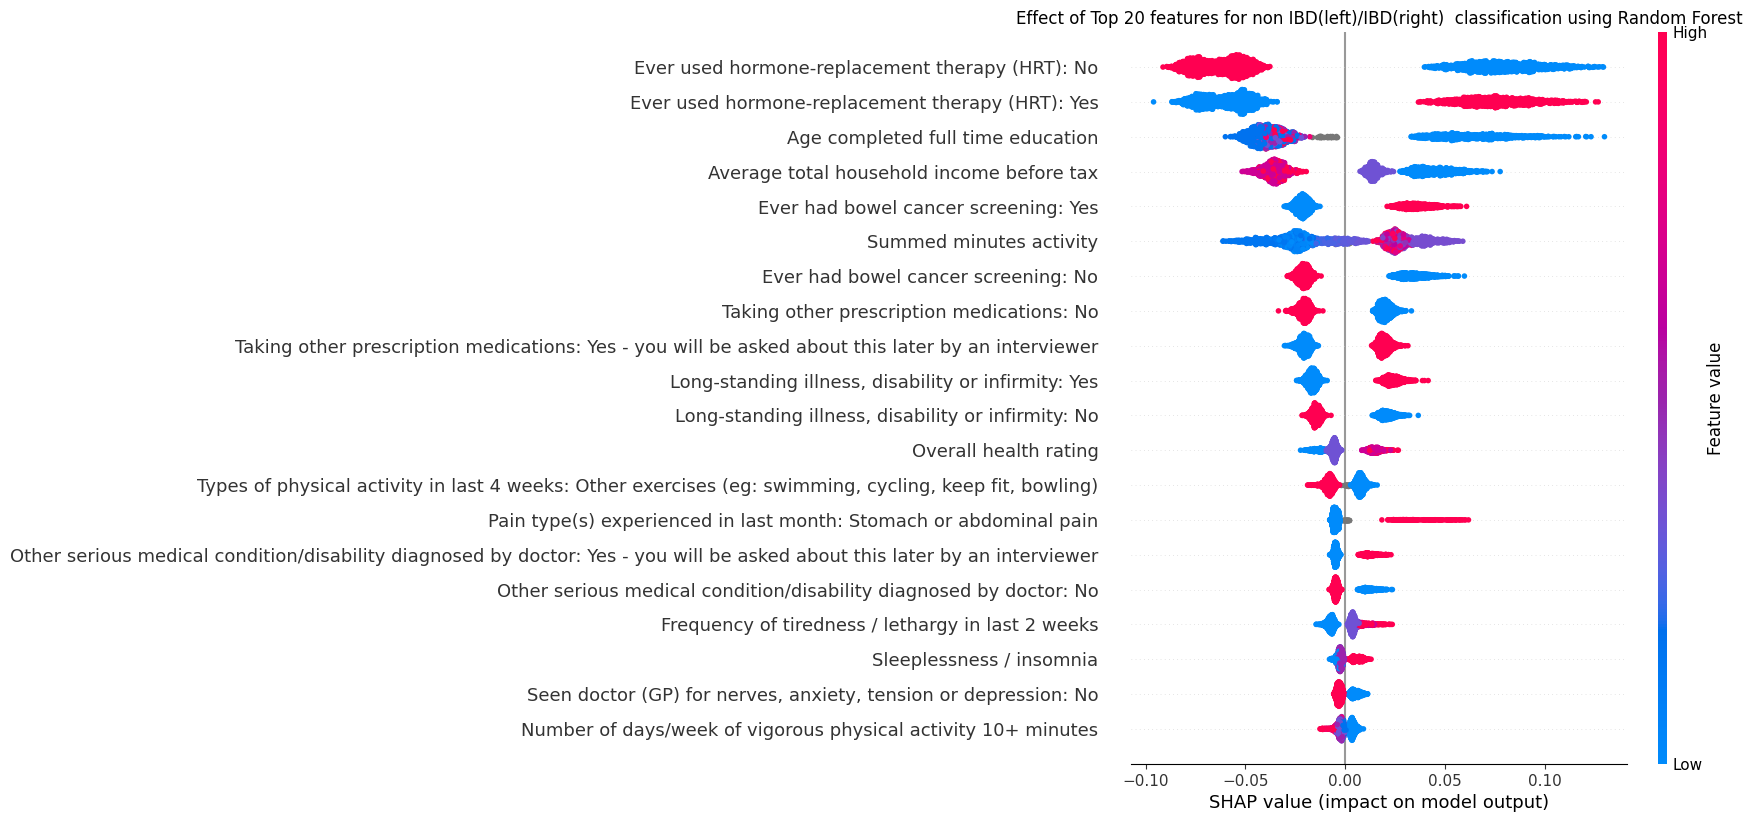

In [88]:
shap.summary_plot(shap_values[:,:,1], X_test, show=False) #ibd
plt.title("Effect of Top 20 features for non IBD(left)/IBD(right)  classification using Random Forest")
plt.show()

In [89]:
#importancia de las variables

importances = clf.feature_importances_
importances_df = pd.DataFrame({'variable': X.columns, 'importancia': importances})
importances_df = importances_df.sort_values(by='importancia', ascending=False)
top_varsRF = importances_df

top_varsRF

,variable,importancia
240,Ever used hormone-replacement therapy (HRT): No,7.669151e-02
239,Ever used hormone-replacement therapy (HRT): Yes,7.265835e-02
276,Age completed full time education,4.872685e-02
314,Average total household income before tax,3.206955e-02
313,Summed minutes activity,2.588092e-02
...,...,...
221,Non-butter spread type details: Hard (block) m...,4.137791e-06
102,Pork intake: Once or more daily,1.487763e-06
266,Ethnic background: Any other Black background,7.231087e-07
259,Ethnic background: Asian or Asian British,0.000000e+00


# Estudio por genero 

## Investigacion en mujeres 

In [27]:
gendre_sex_df = pd.read_csv(os.path.join(path, "genetic_sex.csv"))

gendre_sex_df.head()

,Unnamed: 0,eid,Genetic sex
0,0,1000012,Female
1,1,1000021,Male
2,2,1000035,Female
3,3,1000044,Male
4,4,1000053,Female


### Datos categoricos

#### Datos categoricos simples nominales 

In [26]:
categorical_simple_nominal_female_df.head()

,eid,f_670_0_0,f_680_0_0,f_728_0_0,f_943_0_0,f_1100_0_0,f_1130_0_0,f_1140_0_0,f_1150_0_0,f_1180_0_0,...,f_2784_0_0,f_2814_0_0,f_2834_0_0,f_2844_0_0,f_3393_0_0,f_3591_0_0,f_20160_0_0,f_21000_0_0,f_22035_0_0,f_22036_0_0
28,1000298,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,1.0,5.0,1.0,1.0
75,1000767,1.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1001.0,1.0,1.0
94,1000952,1.0,2.0,3.0,NaN,1.0,NaN,0.0,2.0,1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3001.0,NaN,NaN
129,1001301,2.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN
134,1001358,1.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1001.0,0.0,1.0


In [28]:
# Filtrar eids con sexo genético femenino
female_eids = gendre_sex_df[gendre_sex_df['Genetic sex'] == 'Female']['eid']

# Filtrar el dataframe original con solo esos eids
categorical_simple_nominal_female_df = categorical_simple_nominal_female_df[
    categorical_simple_nominal_female_df['eid'].isin(female_eids)
].copy()

categorical_simple_nominal_female_df.shape

(12742, 73)

In [ ]:
# 1. Merge con información de enfermedad
categorical_simple_nominal_df = categorical_simple_nominal_df.merge(
    ibd0_df[['eid', 'Disease']], on='eid', how='left'
)

# 2. Reclasificar 'Disease' como 'IBD' o 'Control'
categorical_simple_nominal_df['Disease'] = categorical_simple_nominal_df['Disease'].apply(
    lambda x: "IBD" if x in ["CD", "UC", "IBD"] else "Control"
)

# 3. Contar
categorical_simple_nominal_df['Disease'].value_counts(dropna=False)